# 1. Importing Packages and Collecting Data

In [1]:
#Imorting Data Manipulattion Moduls
import numpy as np
import pandas as pd
from scipy import stats
import os, gc

'''Seaborn and Matplotlib Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")                    
%matplotlib inline

'''plotly Visualization'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True)

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [3]:
#Read the dataset from csv file
building = pd.read_csv(r'building_metadata.csv')
weather_train = pd.read_csv(r'weather_train.csv')
weather_test = pd.read_csv(r'weather_test.csv')
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')

# 2. Variable Description and Identification

In [4]:
#Train and test data at a glance.
bold('**Preview of building data**')
display(building.head(3))
bold('**Preview of Weather Train Data:**')
display(weather_train.head(3))
bold('**Preview of Weather Test Data:**')
display(weather_test.head(3))
bold('**Preview of Train Data:**')
display(train.head(3))
bold('**Preview of Test Data:**')
display(test.head(3))

**Preview of building data**

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


**Preview of Weather Train Data:**

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


**Preview of Weather Test Data:**

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1


**Preview of Train Data:**

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0


**Preview of Test Data:**

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00


In [5]:
#mension of train and test data
bold('**Shape of our train and test data**')
print('Dimension of building:', building.shape) 
print('Dimension of Weather train:',weather_train.shape) 
print('Dimension of Weather test:', weather_test.shape)
print('Dimension of train:',train.shape) 
print('Dimension of test:',test.shape)

**Shape of our train and test data**

Dimension of building: (1449, 6)
Dimension of Weather train: (139773, 9)
Dimension of Weather test: (277243, 9)
Dimension of train: (20216100, 4)
Dimension of test: (41697600, 4)


In [6]:
#Merging datasets
train = train.merge(building, on = 'building_id', how = 'left')
test = test.merge(building, on = 'building_id', how = 'left')

train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

del weather_train, weather_test,building

In [7]:
#Function to reduce the DF size
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float64)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2467.79 MB
Memory usage after optimization is: 1677.64 MB
Decreased by 32.0%
Memory usage of dataframe is 5090.04 MB
Memory usage after optimization is: 3460.27 MB
Decreased by 32.0%


In [9]:
#Variable Description
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [10]:
bold('**Variable Description of  train Data:**')
description(train)

**Variable Description of  train Data:**

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0.0,0.0,0.0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float64,12127645,116,2008.0,2004.0,1991.0
8,floor_count,float64,16709167,18,NaN,NaN,NaN
9,air_temperature,float64,96658,619,25.0,25.0,25.0


In [11]:
bold('**Variable Description of  train Data:**')
description(test)

**Variable Description of  train Data:**

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,row_id,int32,0,41697600,0,1,2
1,building_id,int16,0,1449,0,1,2
2,meter,int8,0,4,0,0,0
3,timestamp,category,0,17520,2017-01-01 00:00:00,2017-01-01 00:00:00,2017-01-01 00:00:00
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float64,24598080,116,2008.0,2004.0,1991.0
8,floor_count,float64,34444320,18,NaN,NaN,NaN
9,air_temperature,float64,221901,639,17.8,17.8,17.8


**Well! we have lot of missing value in the both train and test data.**

In [12]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = np.uint8(train["timestamp"].dt.hour)
train["day"] = np.uint8(train["timestamp"].dt.day)
train["weekday_name"] = train["timestamp"].dt.day_name() 
train["weekday"] = np.uint8(train["timestamp"].dt.weekday)
train["month"] = np.uint8(train["timestamp"].dt.month)

test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = np.uint8(test["timestamp"].dt.hour)
test["day"] = np.uint8(test["timestamp"].dt.day)
test["weekday"] = np.uint8(test["timestamp"].dt.weekday)
test["month"] = np.uint8(test["timestamp"].dt.month)

In [13]:
train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

# 3. Exploratory Data Analysis (EDA)

## 3.1 Target Variable Analysis:- meter_reading

In [14]:
#Function to distribution plot
def distplot(variable, color):
    global ax
    font_size = 16
    title_size = 20
    plt.rcParams['figure.figsize'] = (18, 10)
    ax = sns.distplot(variable, color = color)
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.ylabel('Count ', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title(' Distribution of '+'%s' %variable.name, fontsize = title_size)
    plt.show()

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\854870055.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




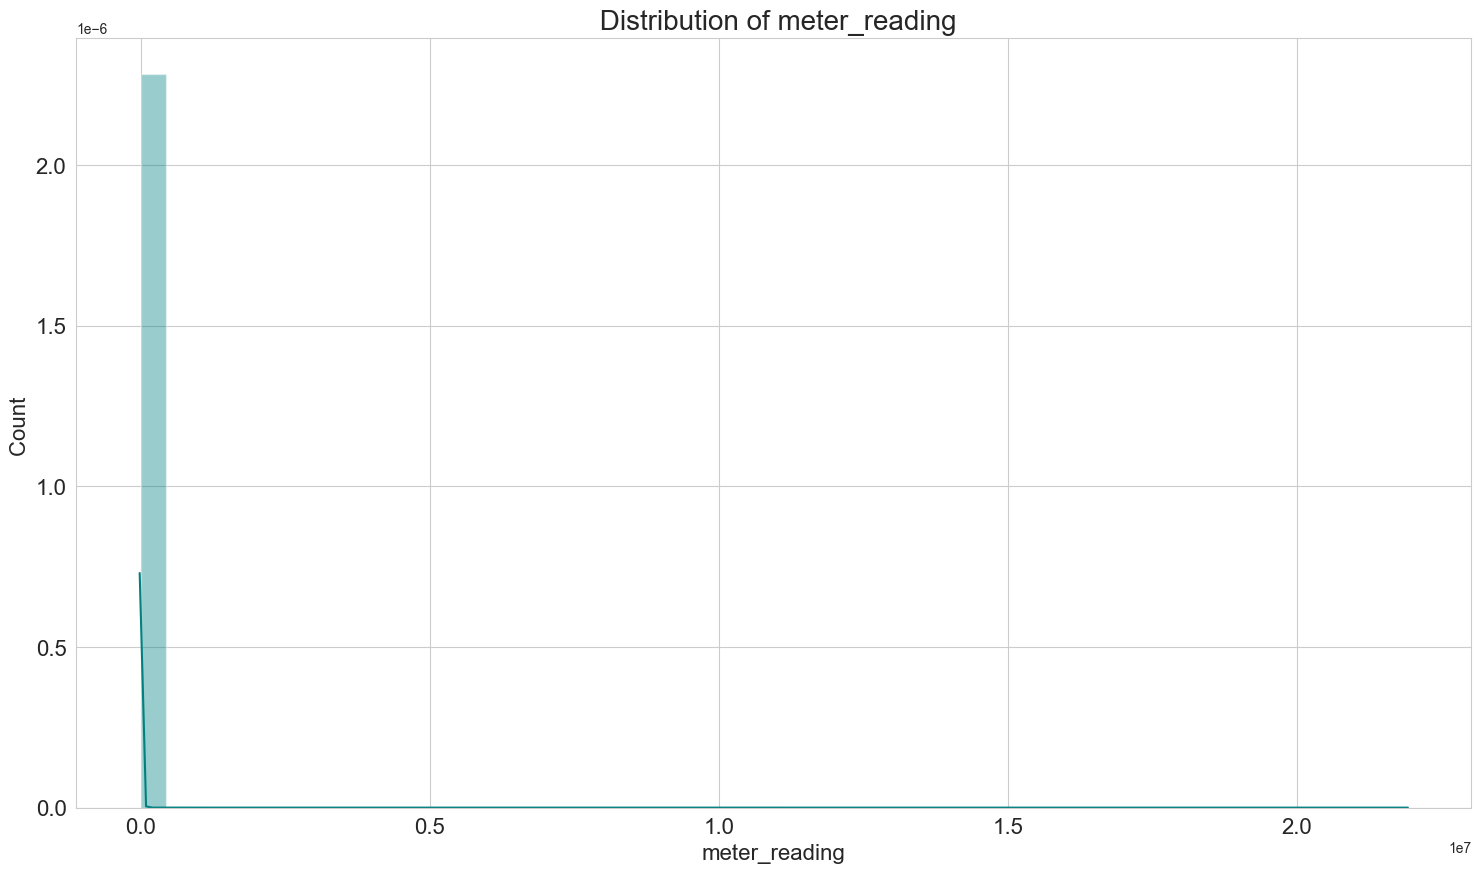

In [15]:
'''Distribution of the Meter Reading'''
distplot(train['meter_reading'], 'teal')

**It's seems that meter reading variable is heavily positive skewed with outliears.
Let's fixed that.**


In [16]:
'''Summary of meter reading'''
train['meter_reading'].describe()

count    2.021610e+07
mean     2.117122e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

**Distribution after log tranformation**

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\854870055.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




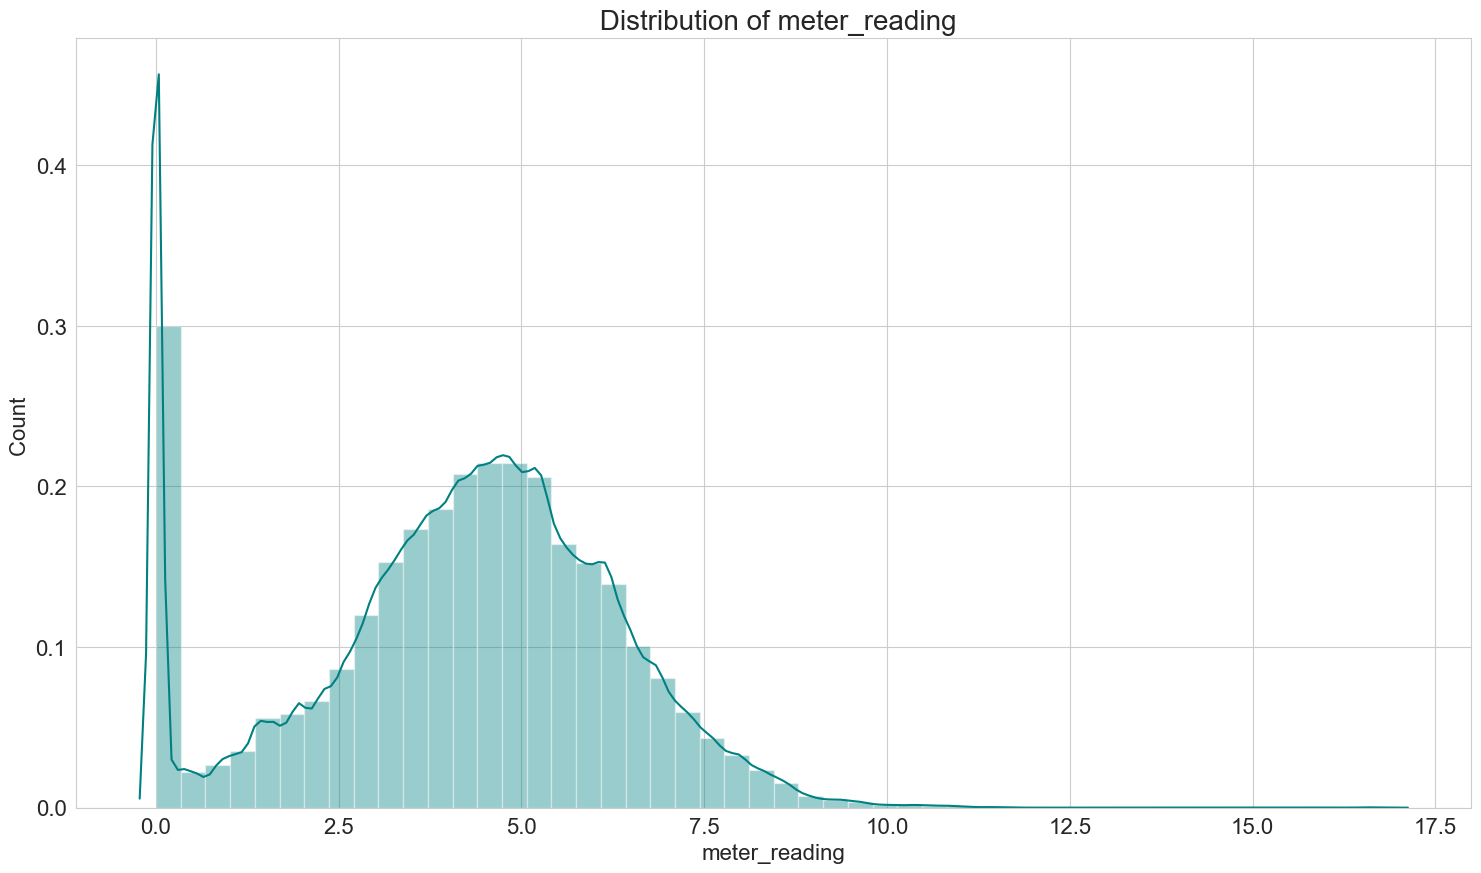

In [17]:
'''Log tranformation of meter_reading'''
train['meter_reading'] = np.log1p(train['meter_reading'])

bold('**Distribution after log tranformation**')
distplot(train['meter_reading'], 'teal')

## 3.2 Meter Reading and Meter Type
There are four different meter types and are displayed below:

* 0: electricity
* 1: chilledwater
* 2: steam
* 3: hotwater

We can see that the steam meter type tends to have higher meter readings, while electricity tends to have the lowest energy readings.

**ELECTRICITY THE MOST FREQUENT METER TYPE MEASURED**

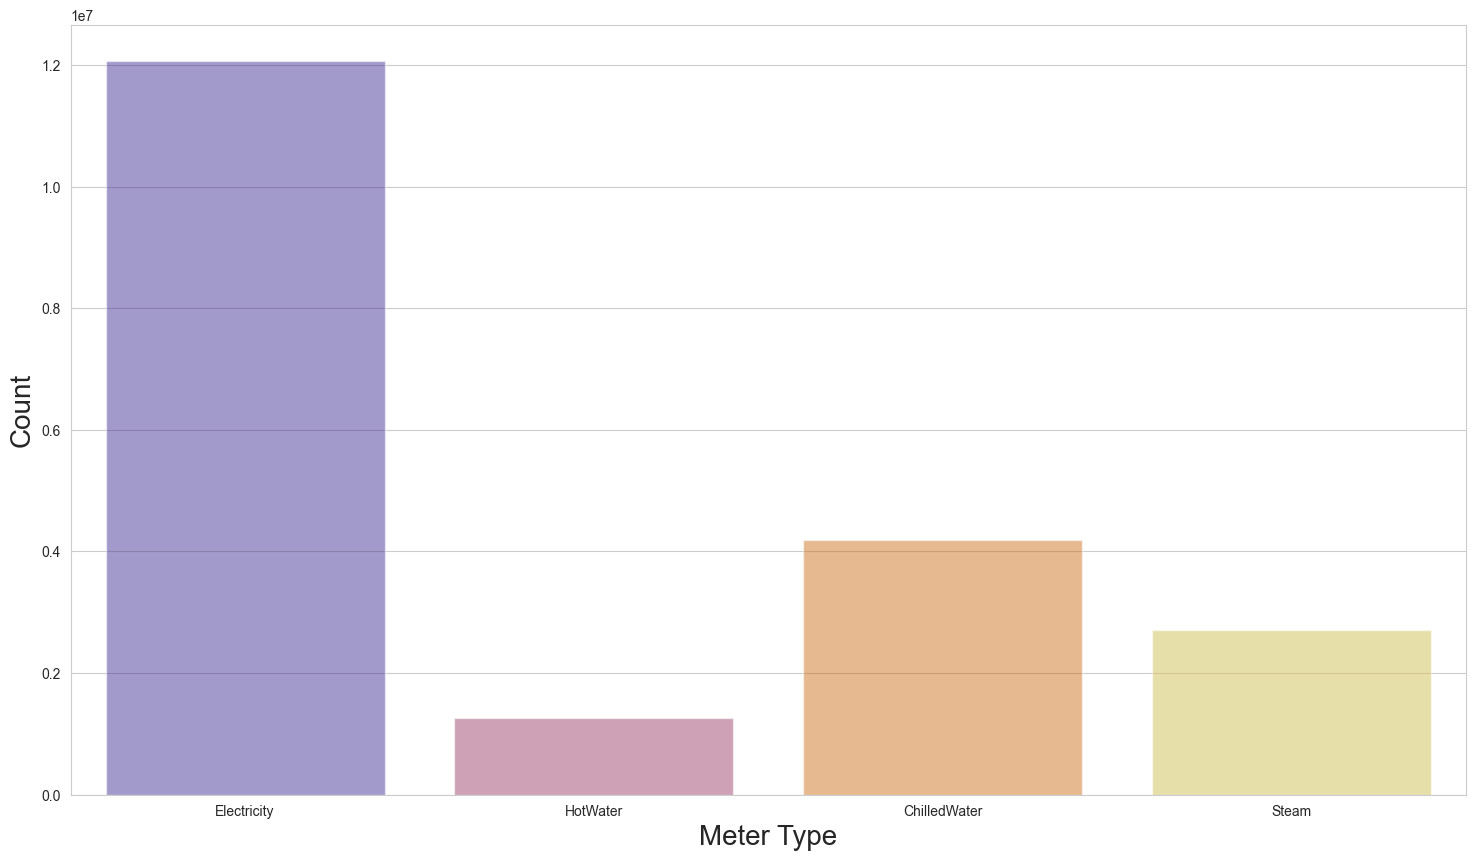

In [18]:
bold('**ELECTRICITY THE MOST FREQUENT METER TYPE MEASURED**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(data = train, x ='meter', palette = 'CMRmap', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Meter Type', fontsize = 20)
plt.show()

**THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT**

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\1787391848.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\1787391848.py:7: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\1787391848.py:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\1787391848.py:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




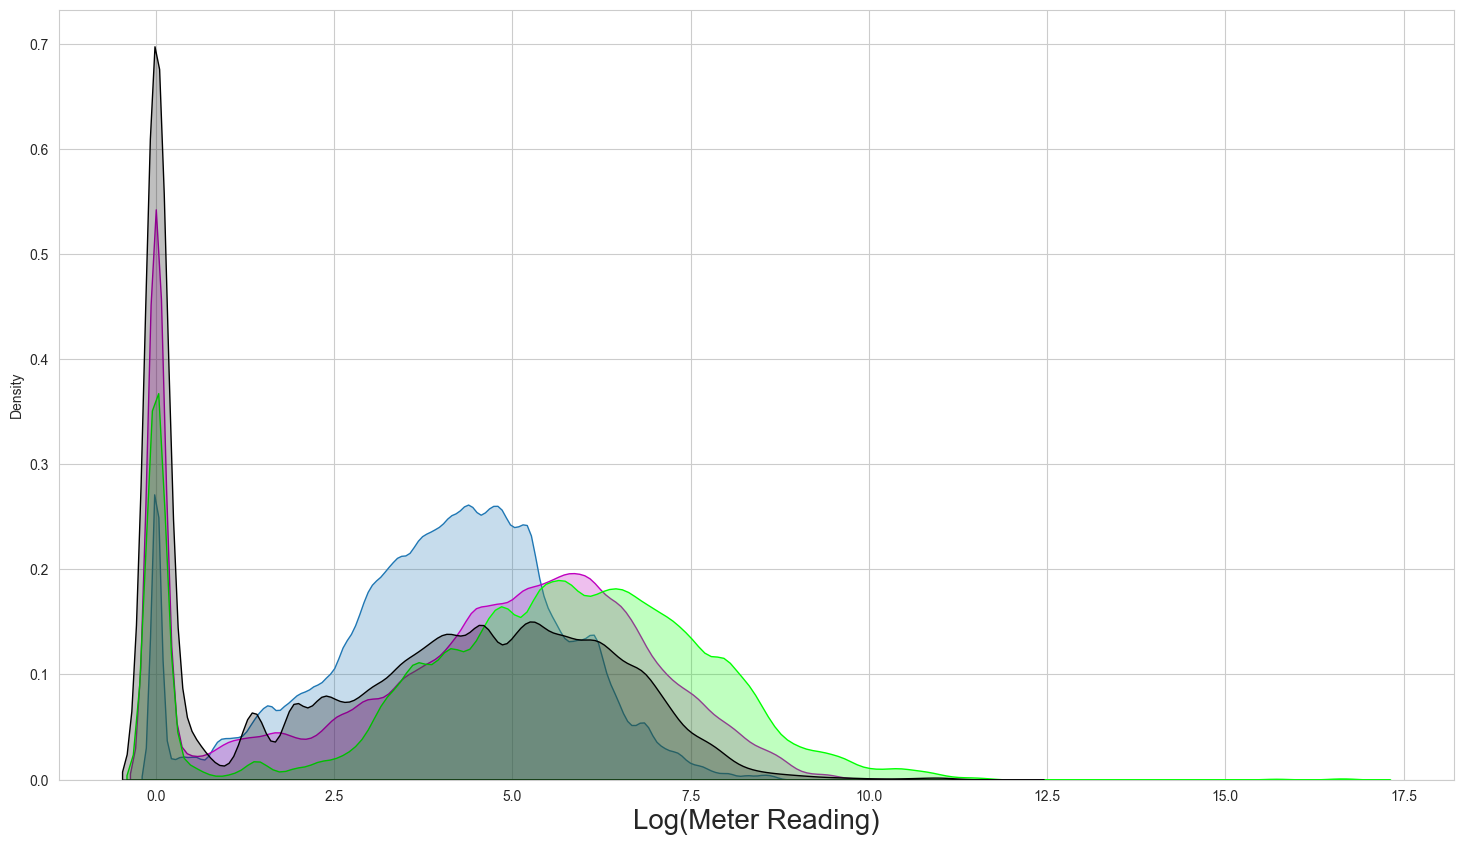

In [19]:
bold('**THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT**')
plt.rcParams['figure.figsize'] = (18, 10)

temp_df = train[train["meter"]=="Electricity"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="electricity")
temp_df = train[train["meter"]=="ChilledWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="chill water", color = 'm')
temp_df = train[train["meter"]=="Steam"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="steam", color = 'lime')
temp_df = train[train["meter"]=="HotWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="hot water", color = 'k')
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
plt.show()

## 3.3 Weekday and Meter Reading

**SUNDAYS HAVE THE LOWEST READINGS**

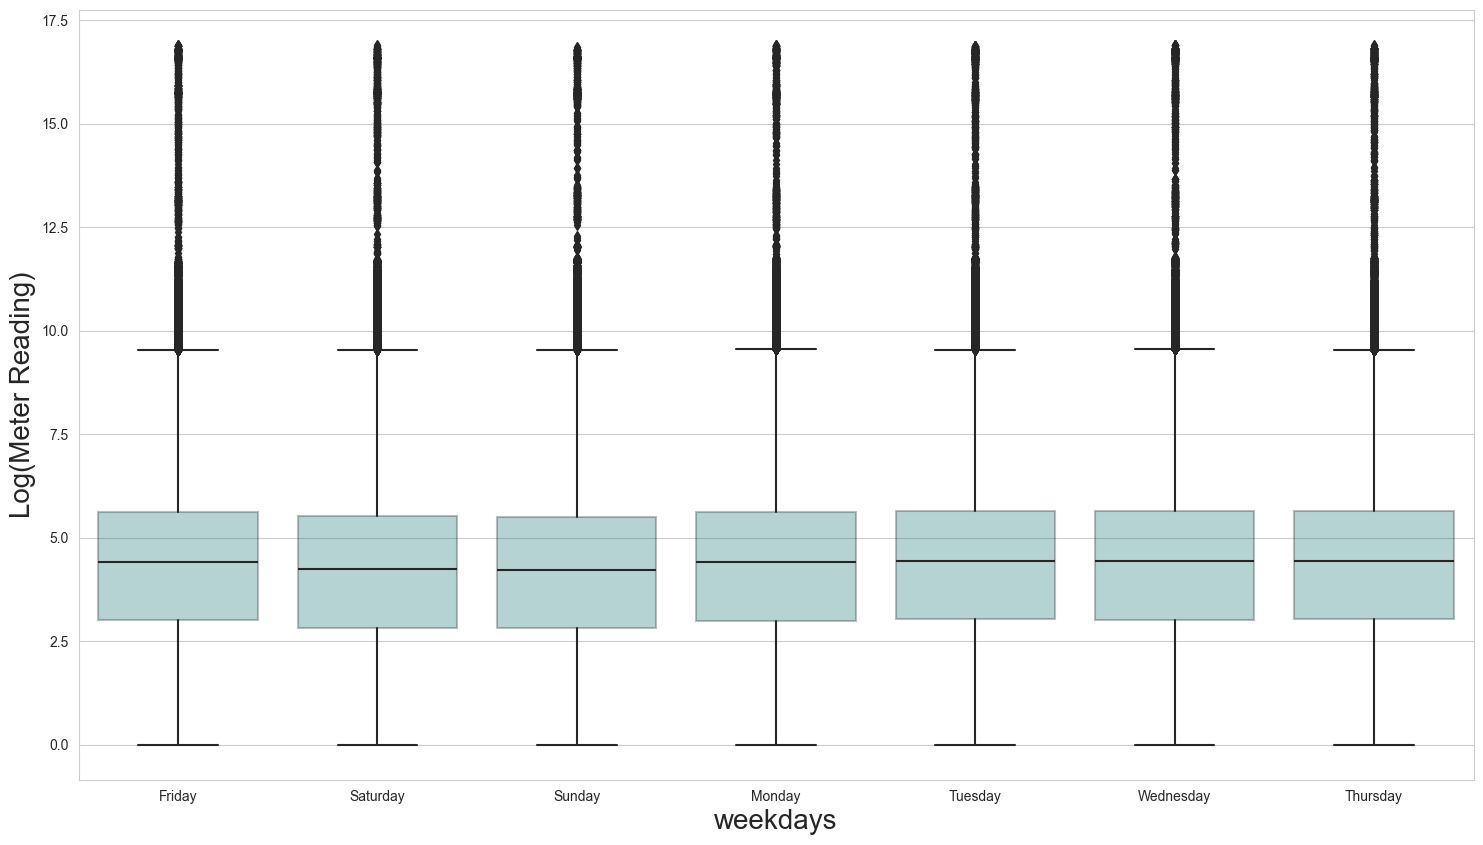

In [20]:
bold('**SUNDAYS HAVE THE LOWEST READINGS**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.boxplot(data = train, x ='weekday_name', y = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_ylabel('Log(Meter Reading)', fontsize = 20)
ax.set_xlabel('weekdays', fontsize = 20)
plt.show()

## 3.4 Time of Day and Meter Reading

**READINGS HIGHEST DURING THE MIDDLE OF THE DAY**

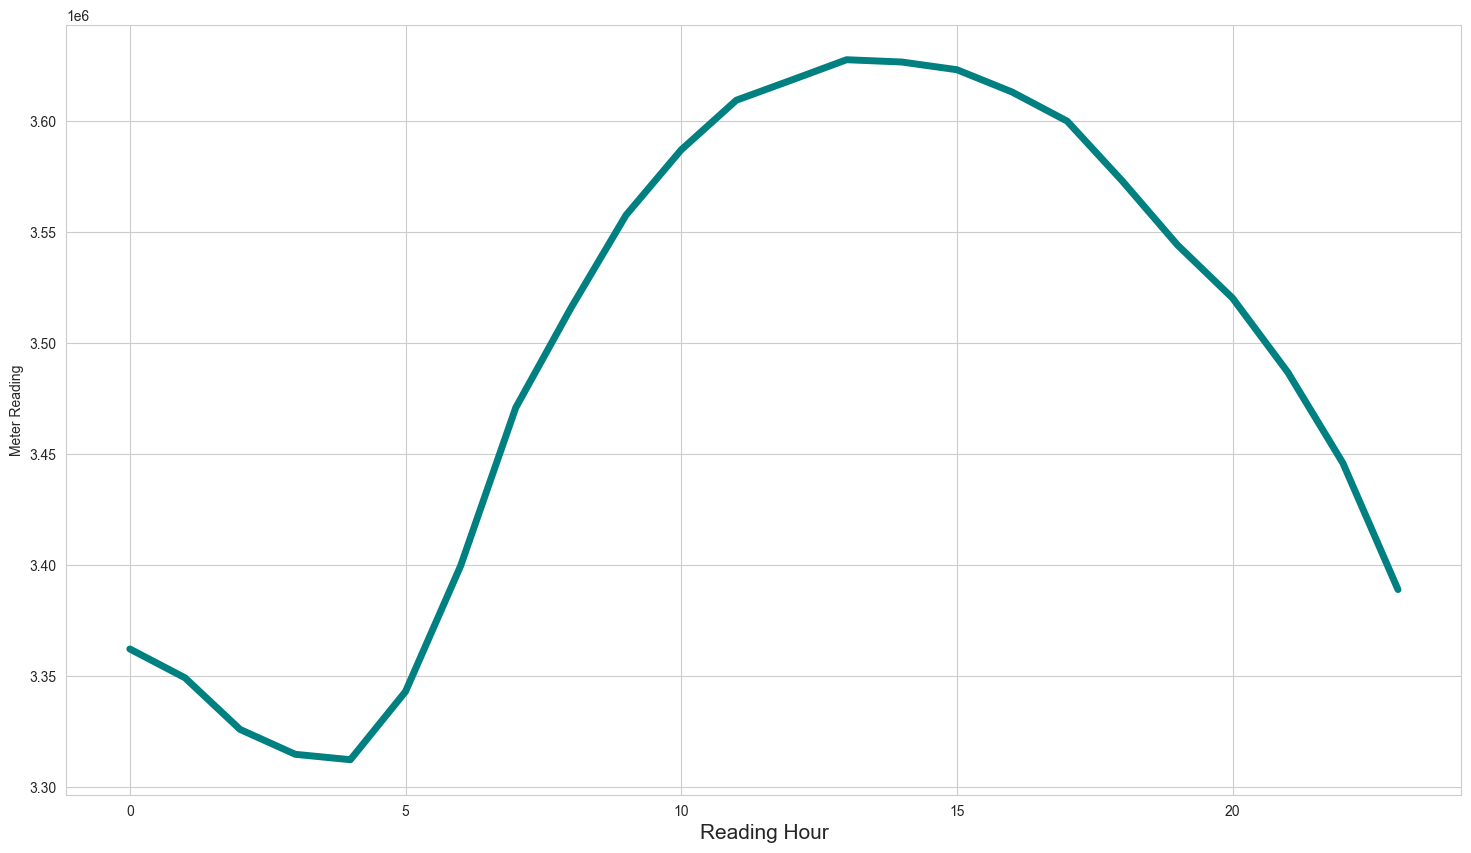

In [21]:
bold('**READINGS HIGHEST DURING THE MIDDLE OF THE DAY**')
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby('hour').meter_reading.sum()
temp_df.plot(linewidth = 5, color = 'teal')
plt.xlabel('Reading Hour', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

# 3.5 Primary Use and Meter Reading

**MONTHLY READINGS ARE HIGHEST CHANGES BASED ON BUILDING TYPE**

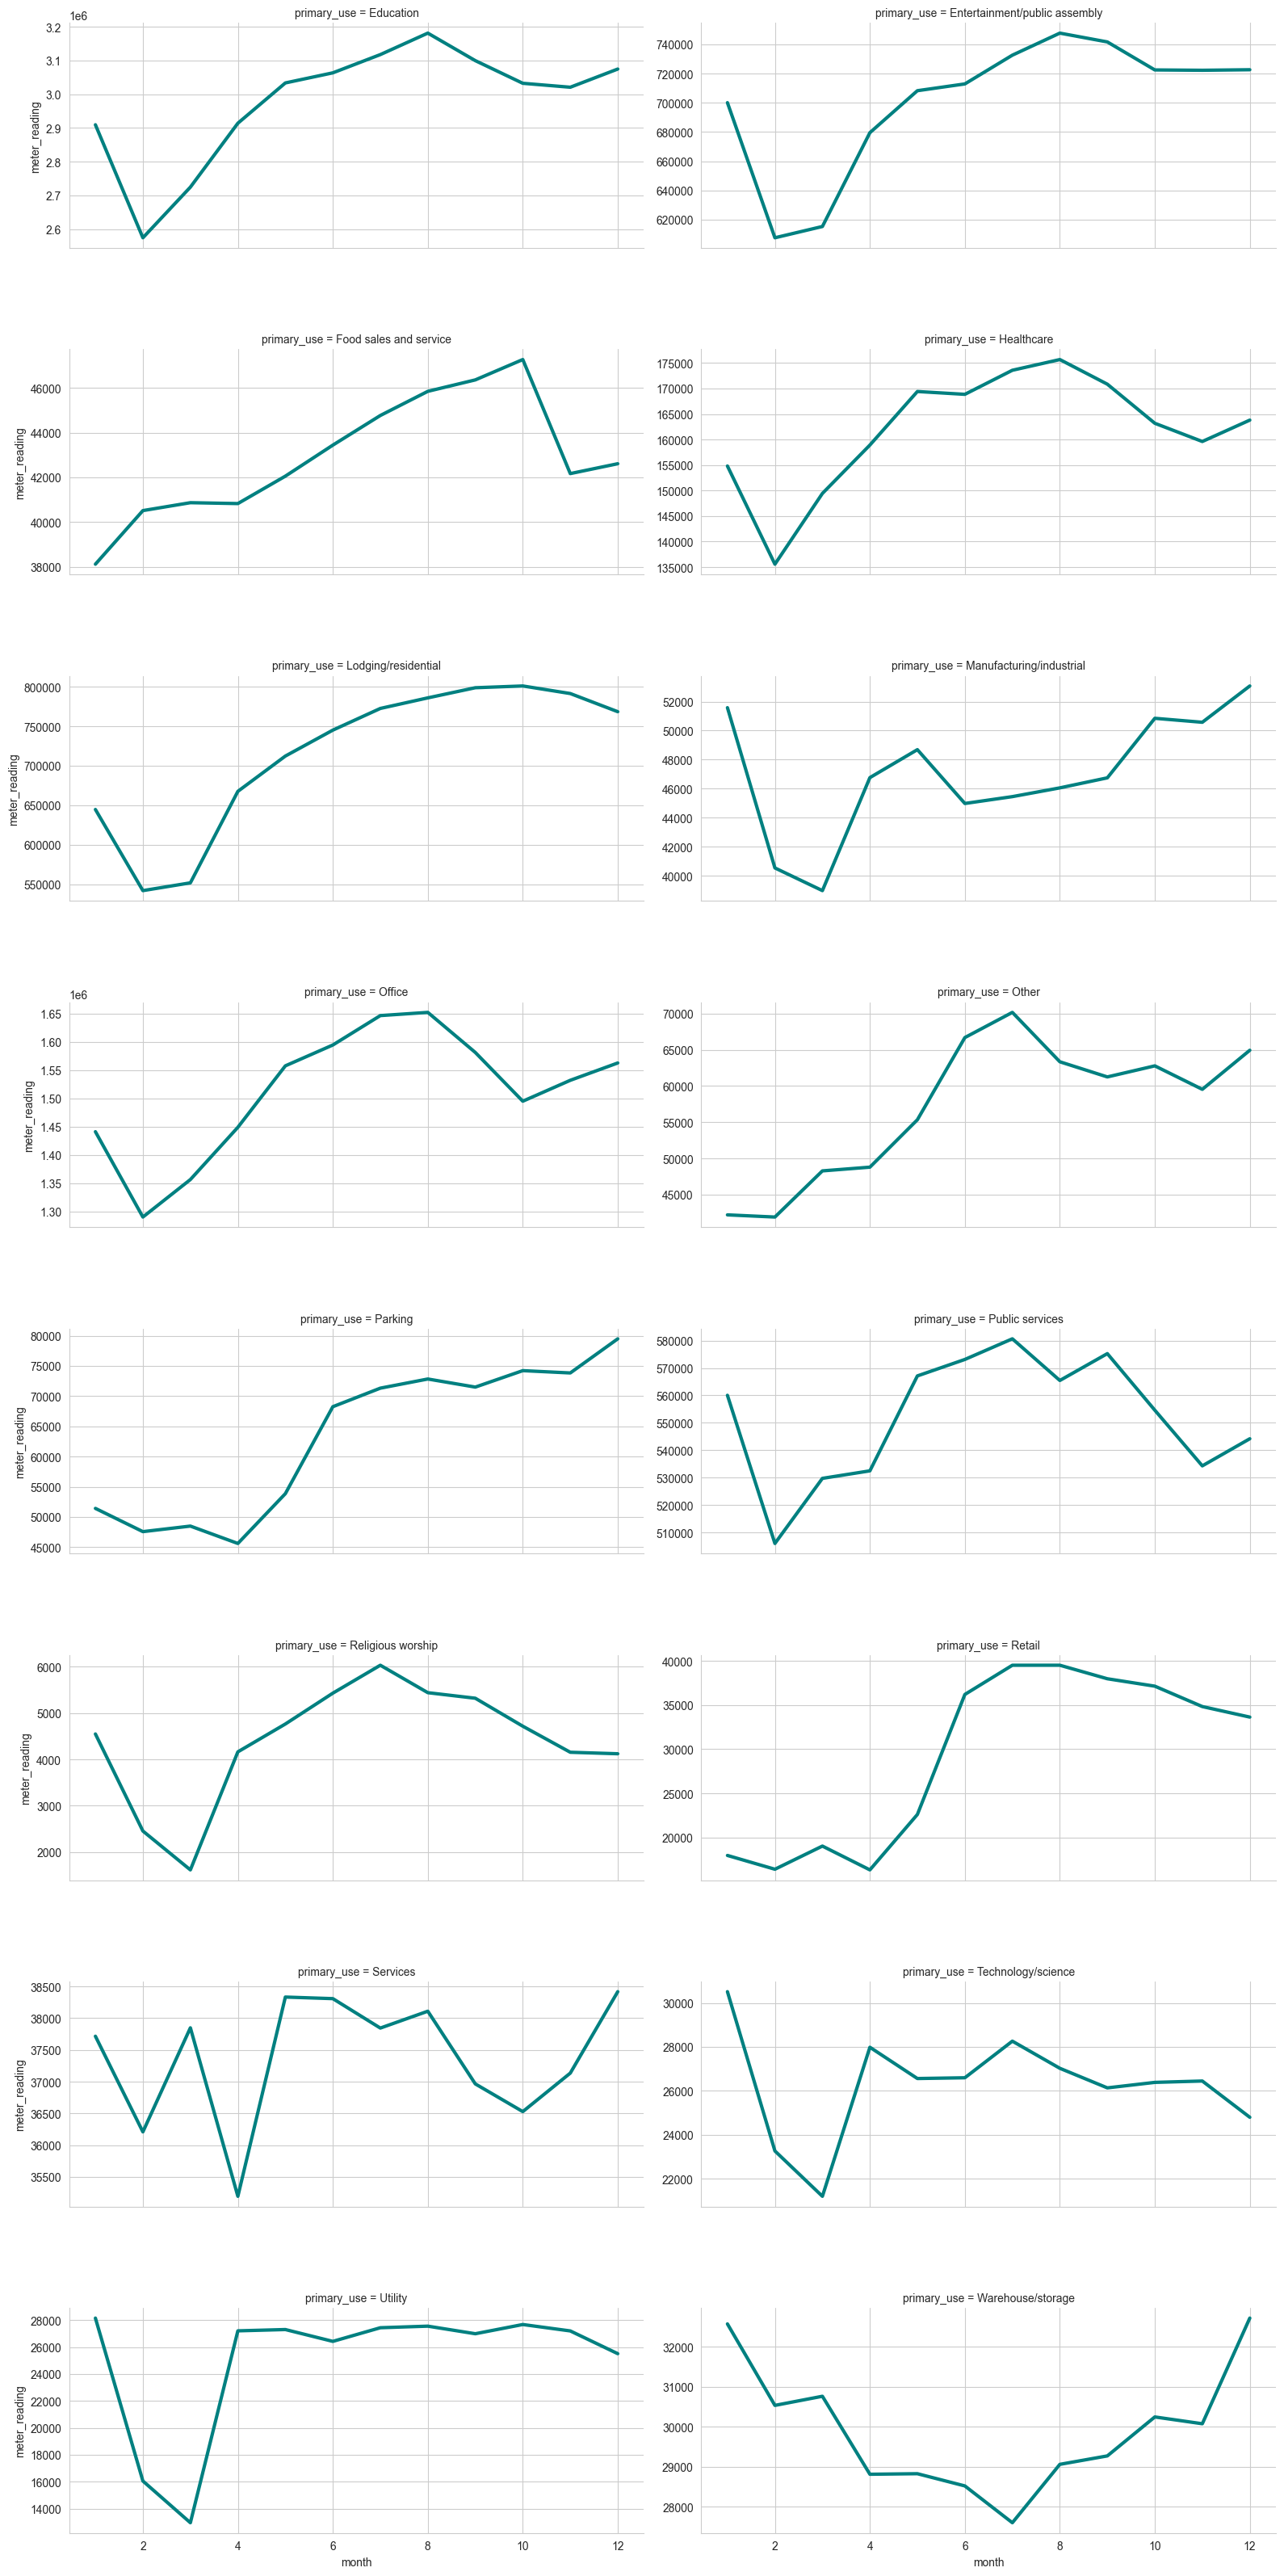

In [22]:
bold('**MONTHLY READINGS ARE HIGHEST CHANGES BASED ON BUILDING TYPE**')
temp_df = train.groupby(['month', 'primary_use']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'month', 'meter_reading', color="teal", linewidth = 3)
plt.subplots_adjust(hspace=0.45)
plt.show()

There are considerable differences between building types as to when meter readings are highest. Almost all the building peak in the end of the year due to winter season.

The trend holds for most of the different building types, with a few notable exceptions; Manufacturing dips during that peak period outlined above, while Services, Technology, Utility and Warehouse remained fairly constant over the year.

**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**

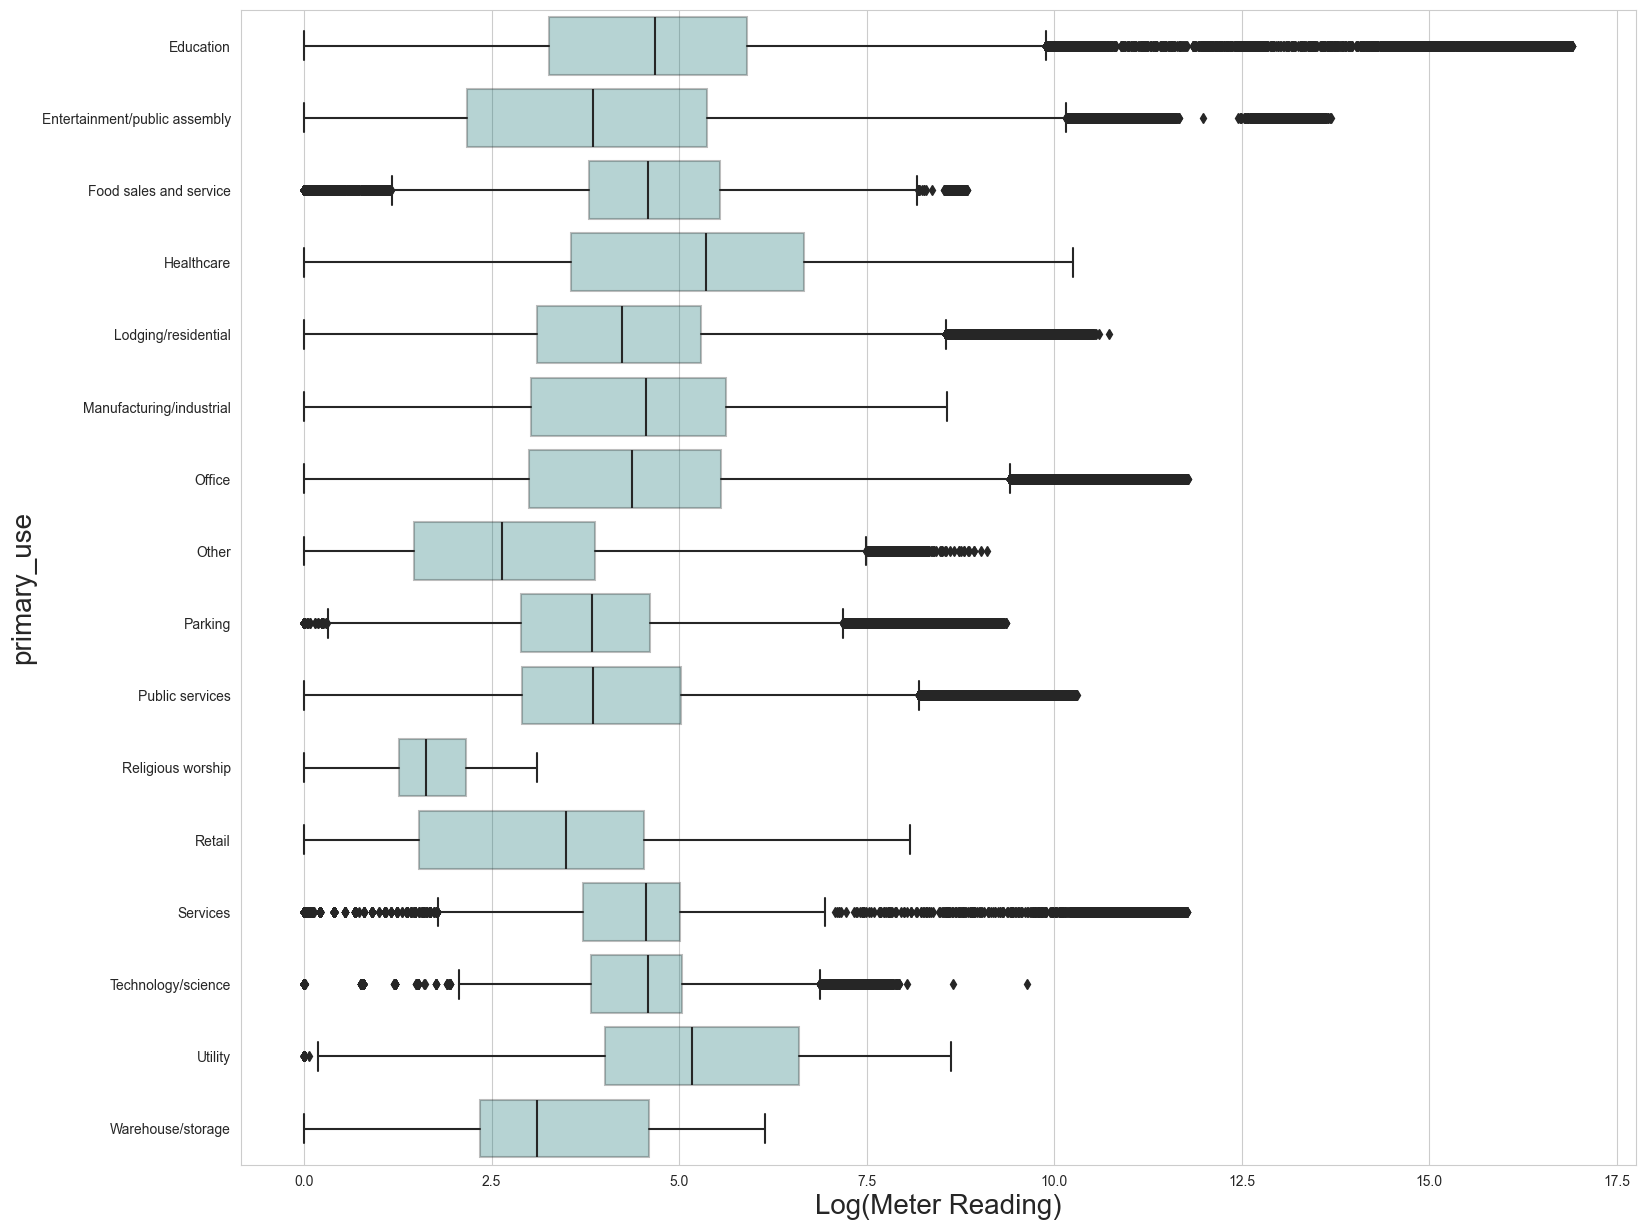

In [23]:
bold('**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**')
plt.rcParams['figure.figsize'] = (18, 15)
ax = sns.boxplot(data = train, y ='primary_use', x = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
ax.set_ylabel('primary_use', fontsize = 20)
plt.show()

We can see that Utility and Healthcare places tend to have the highest readings, while Religious Worship places the least - they’re no doubt frequented less often than the higher energy users.

**PLACES OF INDUSTRY HIGHEST READINGS ON WEEKDAYS**

C:\Program Files\Python311\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



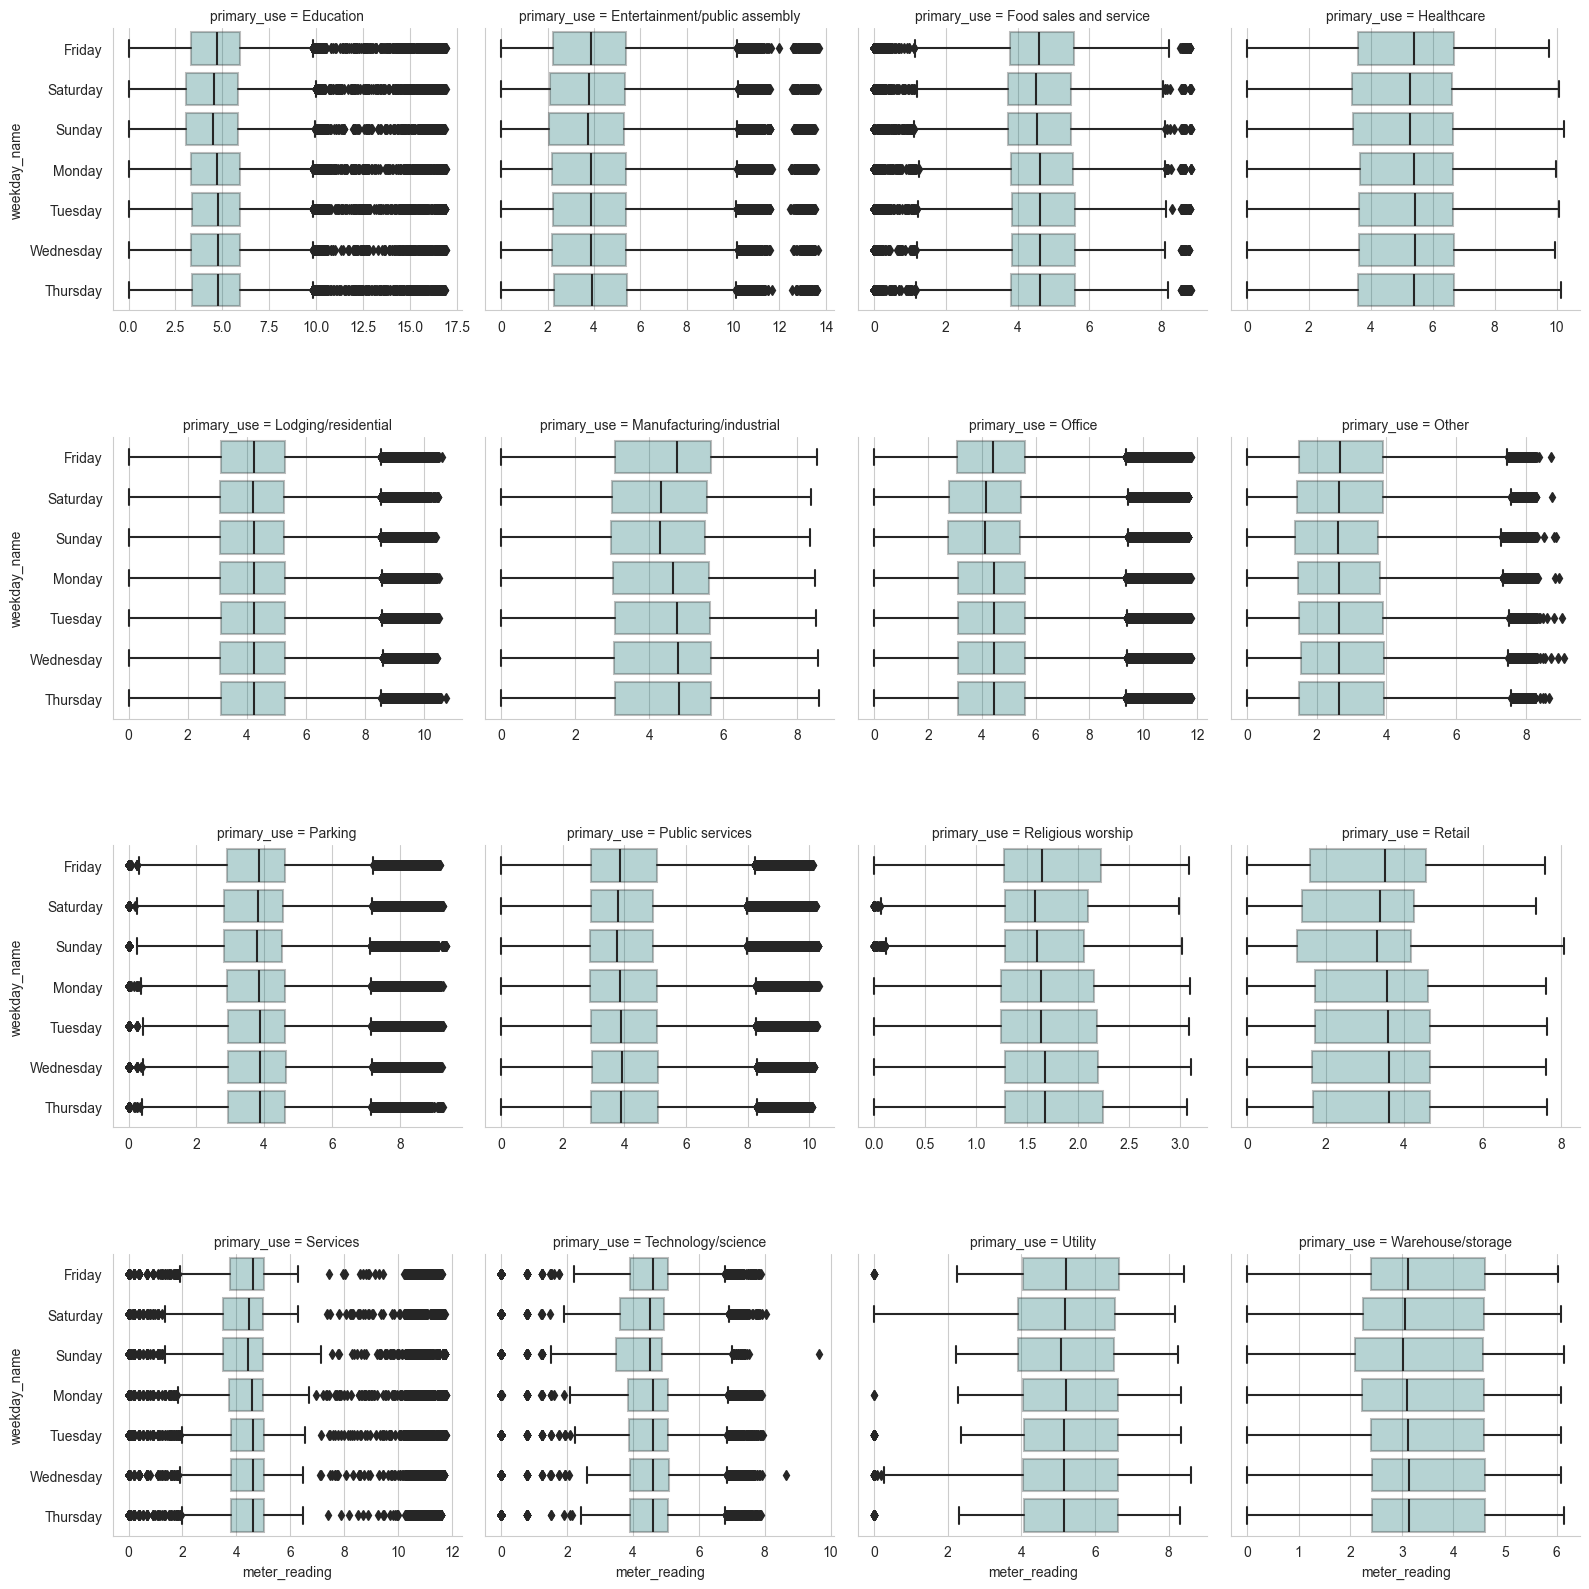

In [24]:
bold('**PLACES OF INDUSTRY HIGHEST READINGS ON WEEKDAYS**')
ax = sns.FacetGrid(train, col="primary_use", col_wrap=4, height=4, aspect=1,  sharex=False)
ax.map(sns.boxplot, 'meter_reading', 'weekday_name', color="teal",   boxprops=dict(alpha=.3))
plt.subplots_adjust(hspace=0.45)
plt.show()

Healthcare, Education, Manufacturing/ Industrial, Techonology/science, Utilities building has highest reading on weekdays compares to the others.

Religious worship places have higher readings on weekends.



## 3.6 Meter Readings over time

**READINGS REALLY PEAKED FROM MAY TO OCTOBER**

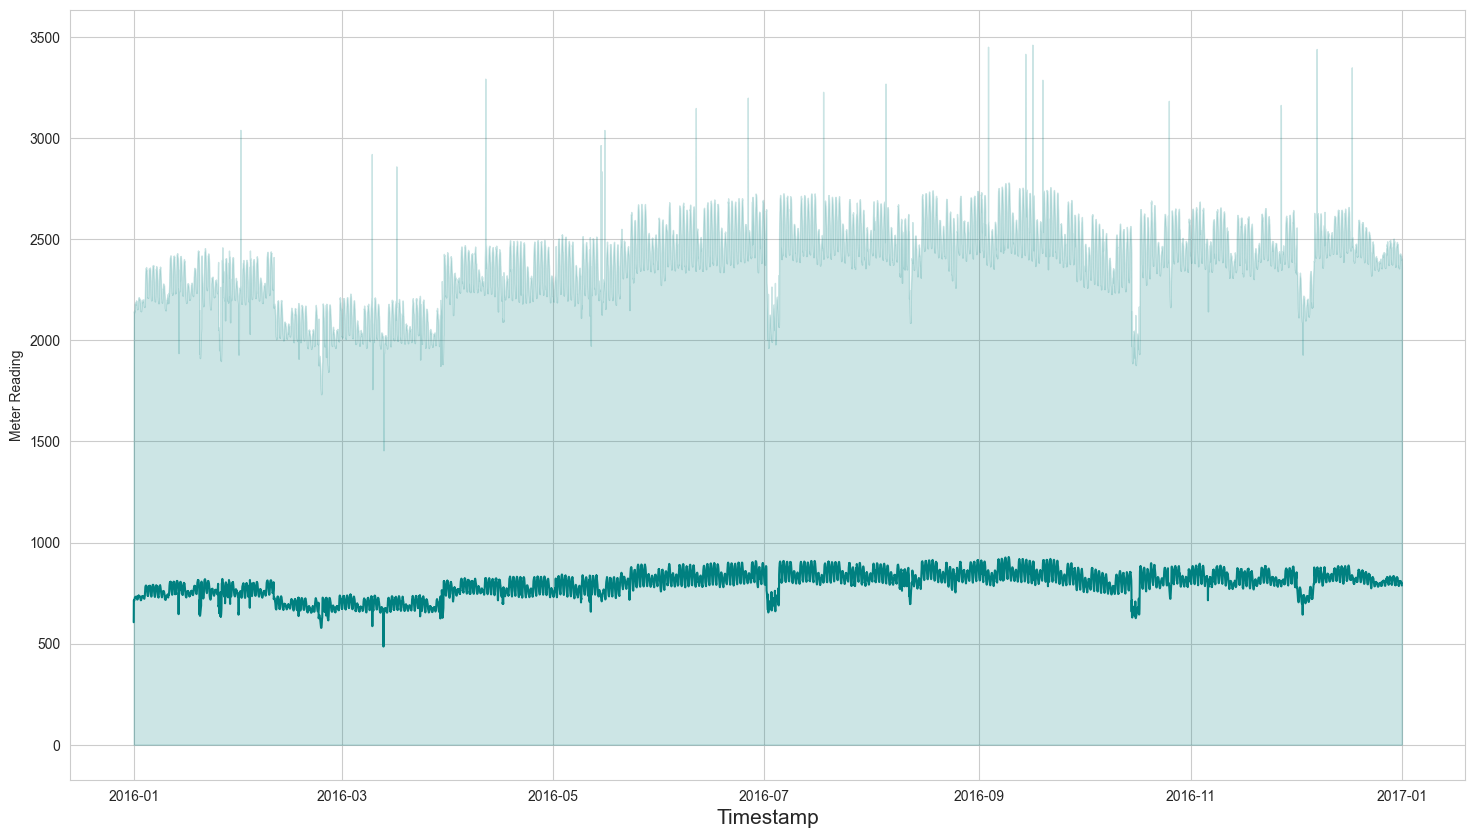

In [25]:
bold('**READINGS REALLY PEAKED FROM MAY TO OCTOBER**')
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby(['timestamp', 'month']).meter_reading.sum().reset_index()
ax = sns.lineplot(data = temp_df, x = 'timestamp', y = 'meter_reading', color = 'teal')
plt.xlabel('Timestamp', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

Interestingly, the meter reading per reading began rising in May and peaked between July and October 2016.

### Meter Readings over time And Primary Use

**MANUFACTURING REALLY BUCKED THE GENERAL TREND**

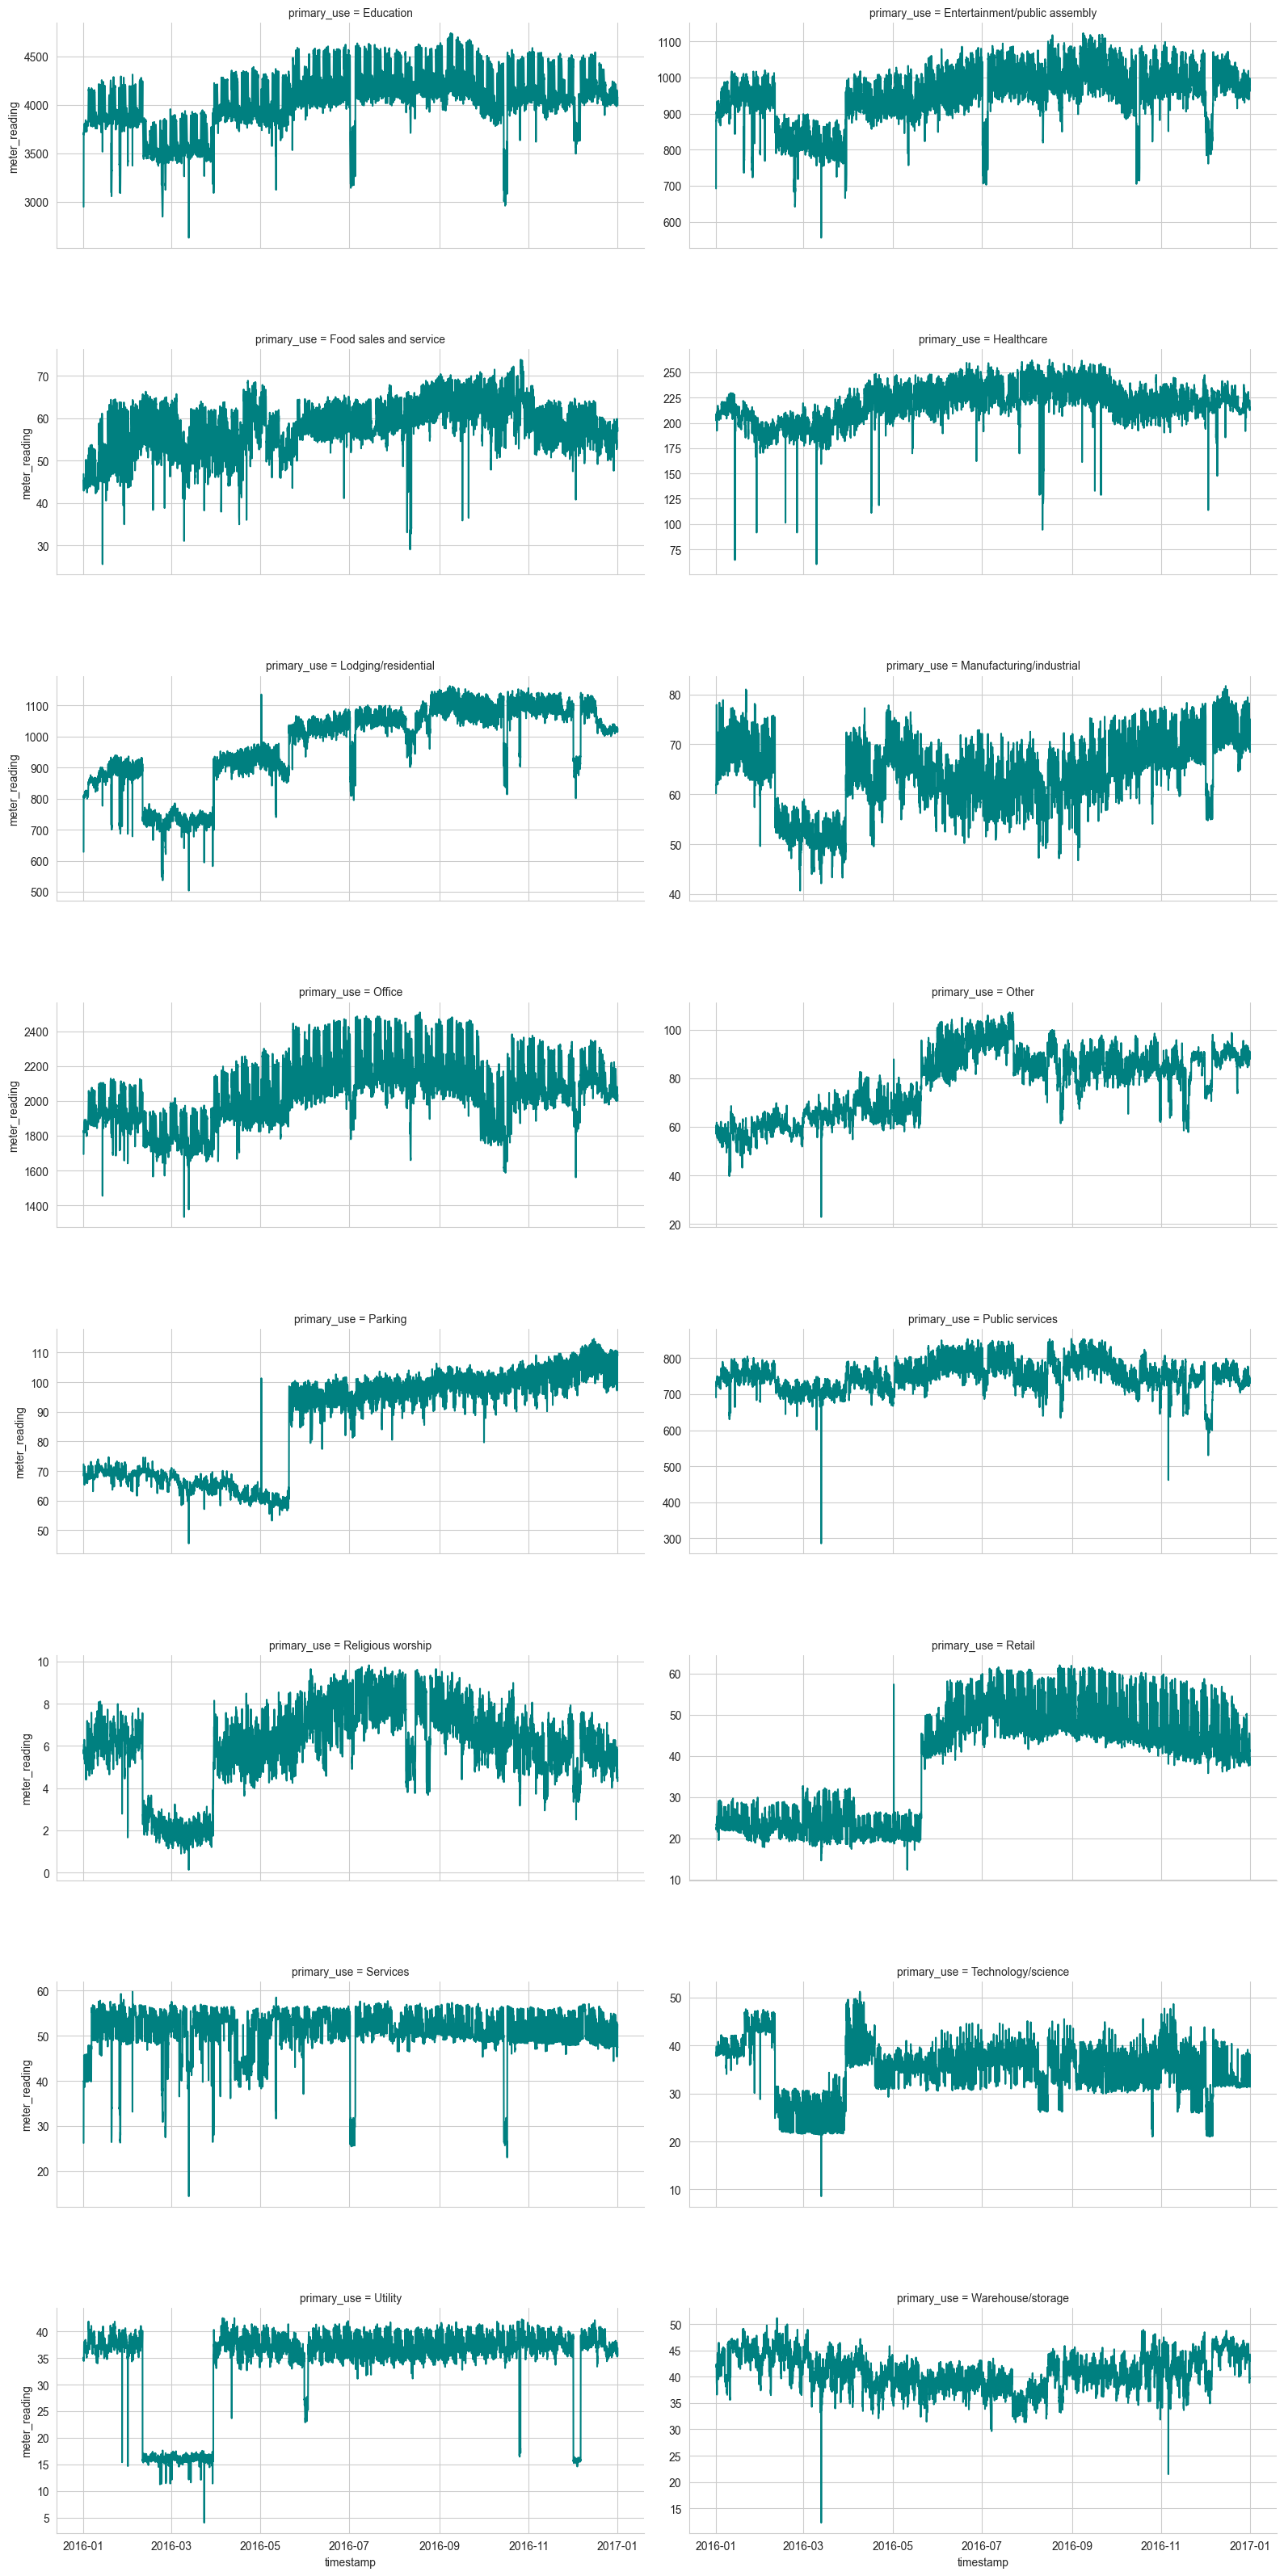

In [26]:
bold('**MANUFACTURING REALLY BUCKED THE GENERAL TREND**')
temp_df = train.groupby(['timestamp', "primary_use"]).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(sns.lineplot,'timestamp',  'meter_reading', color="teal")
plt.subplots_adjust(hspace=0.45)
plt.show()

The trend holds for most of the different building types, with a few notable exceptions; Manufacturing dips during that peak period outlined above, while Services, Technology, Utility and Warehouse remained fairly constant over the year.

## 3.7 Correlation between meter_reading And Numeric Variable

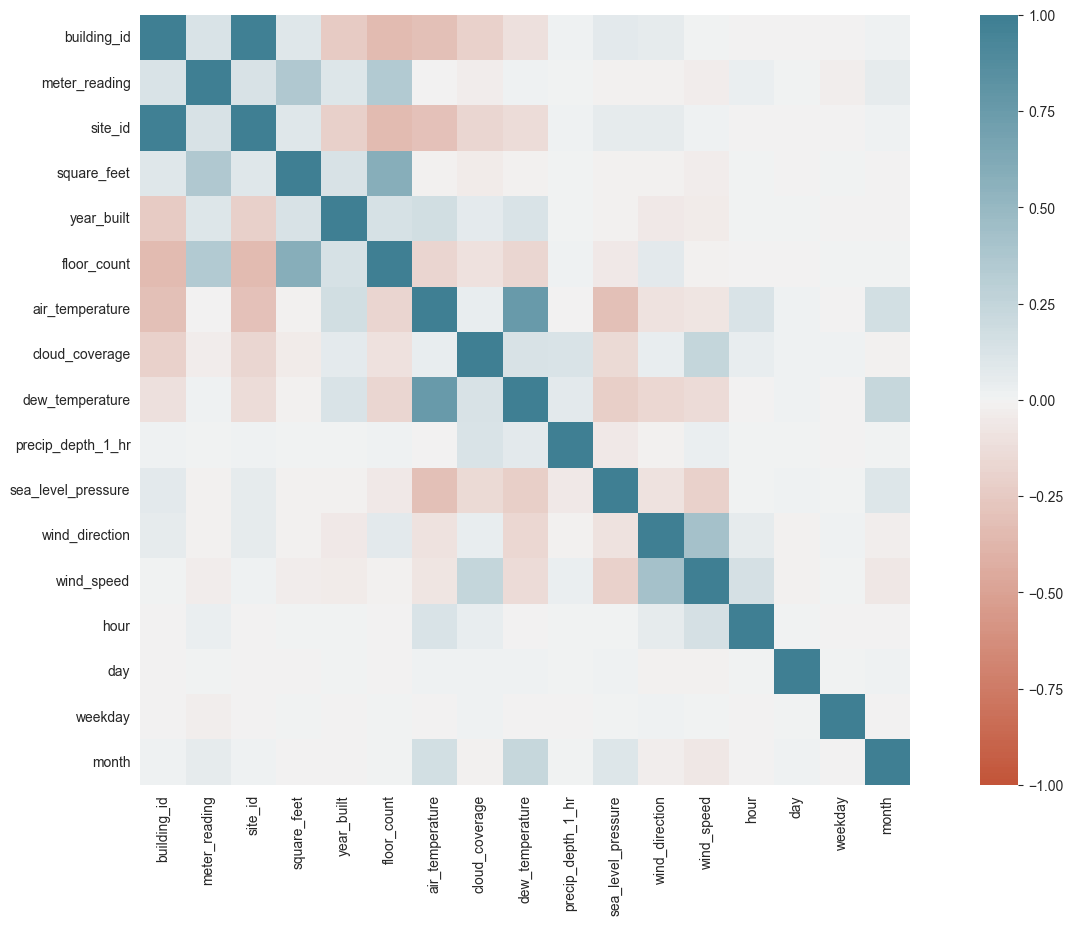

In [27]:
########Newly Added#############
plt.rcParams['figure.figsize'] = (18,10)
train_numeric = train.select_dtypes(include=['number'])

sns.heatmap(train_numeric.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

Square feet and floor count highly positive correlated ie, the bigger the building, the higher the reading and year building build and meter type moderate positive correlated also.

wind_speed, air_temperature and cloud_coverage may be important in any model that gets built.

## 3.8 Square Feet

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\854870055.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




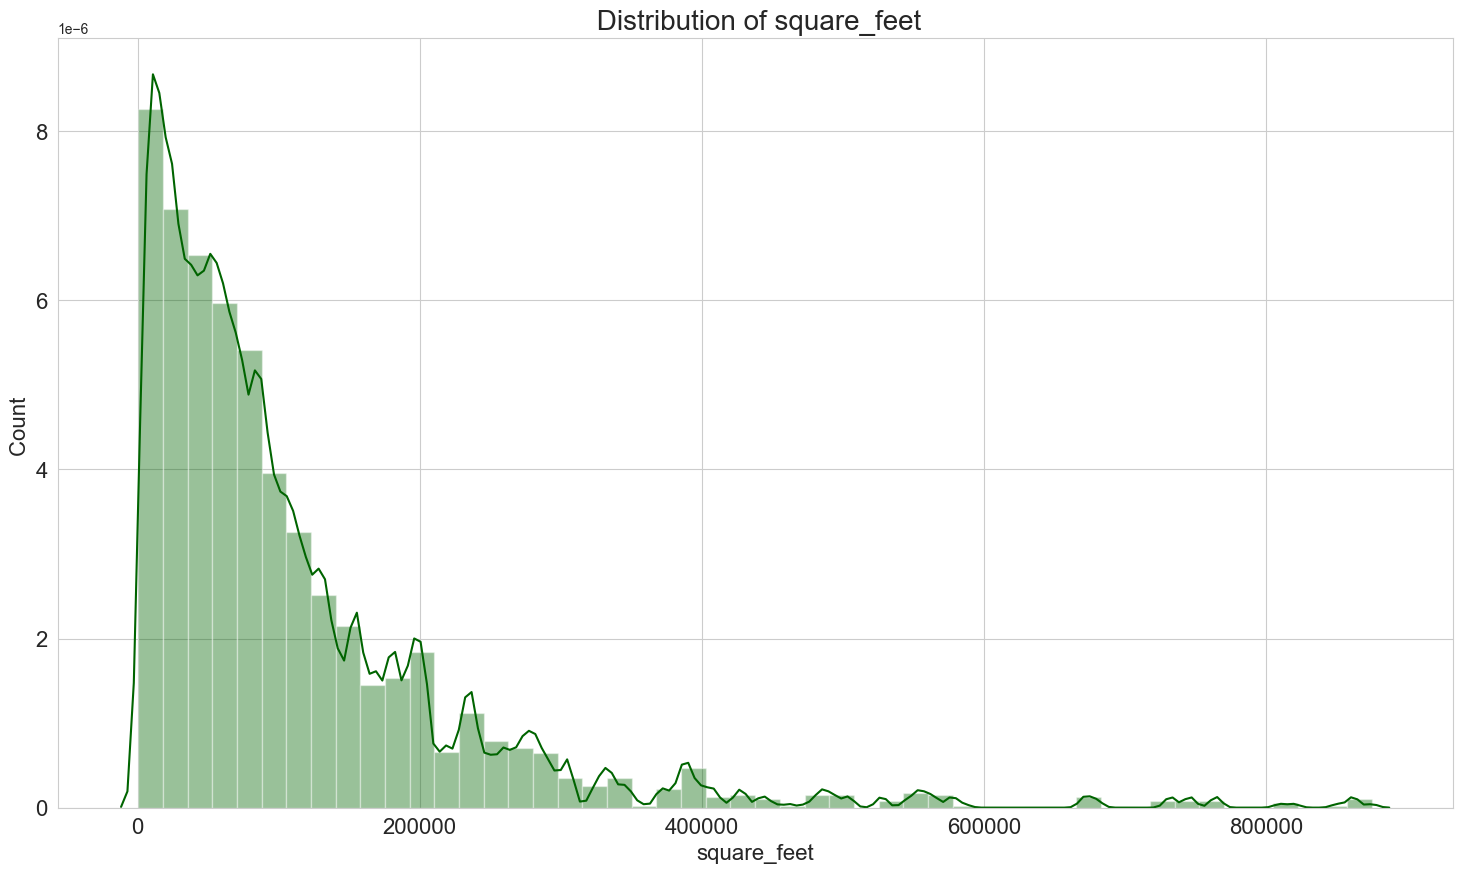

In [28]:
'''Distribution of the Meter Reading'''
distplot(train['square_feet'], 'darkgreen')

Square feet size is positively Skewed.

**Distribution after log tranformation**

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\854870055.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




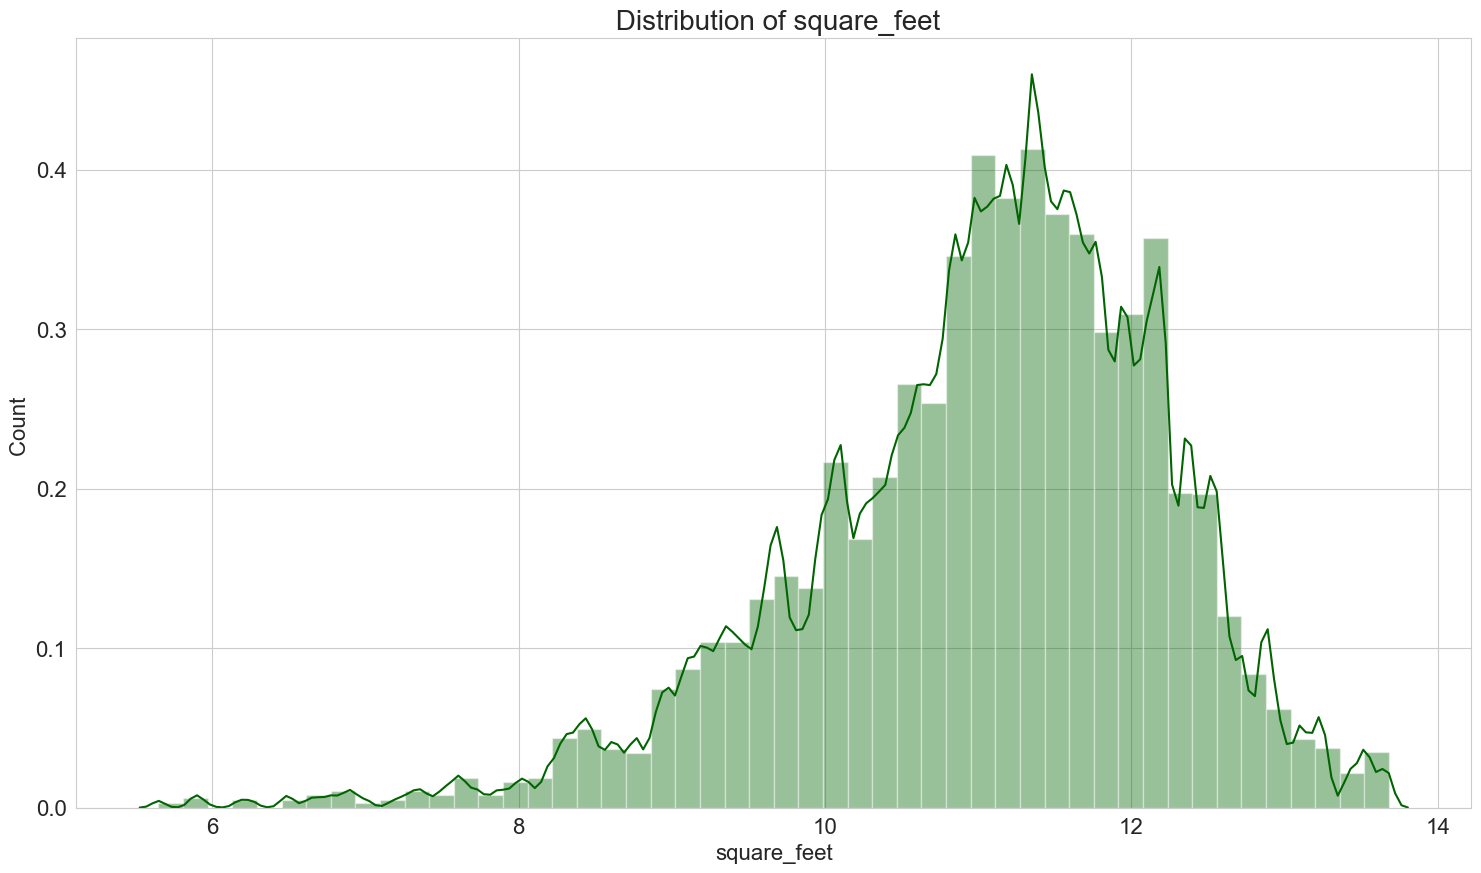

In [29]:
#Log tranformation of meter_reading
train['square_feet'] = np.log1p(train['square_feet'])
test['square_feet'] = np.log1p(test['square_feet'])

bold('**Distribution after log tranformation**')
distplot(train['square_feet'], 'darkgreen')

## 3.9 Year Built

In [30]:
#plt.rcParams['figure.figsize'] = (18,10)
#temp_df = train.groupby('year_built').building_id.sum().reset_index()
#ax = sns.lineplot(data = temp_df, x = 'year_built', y = 'building_id', color = 'black', linewidth = 3.5)
#plt.xlabel('Year Built', fontsize = 15)
#plt.ylabel('Building_ID', fontsize = 15)
#plt.show()

12127645
[nan]


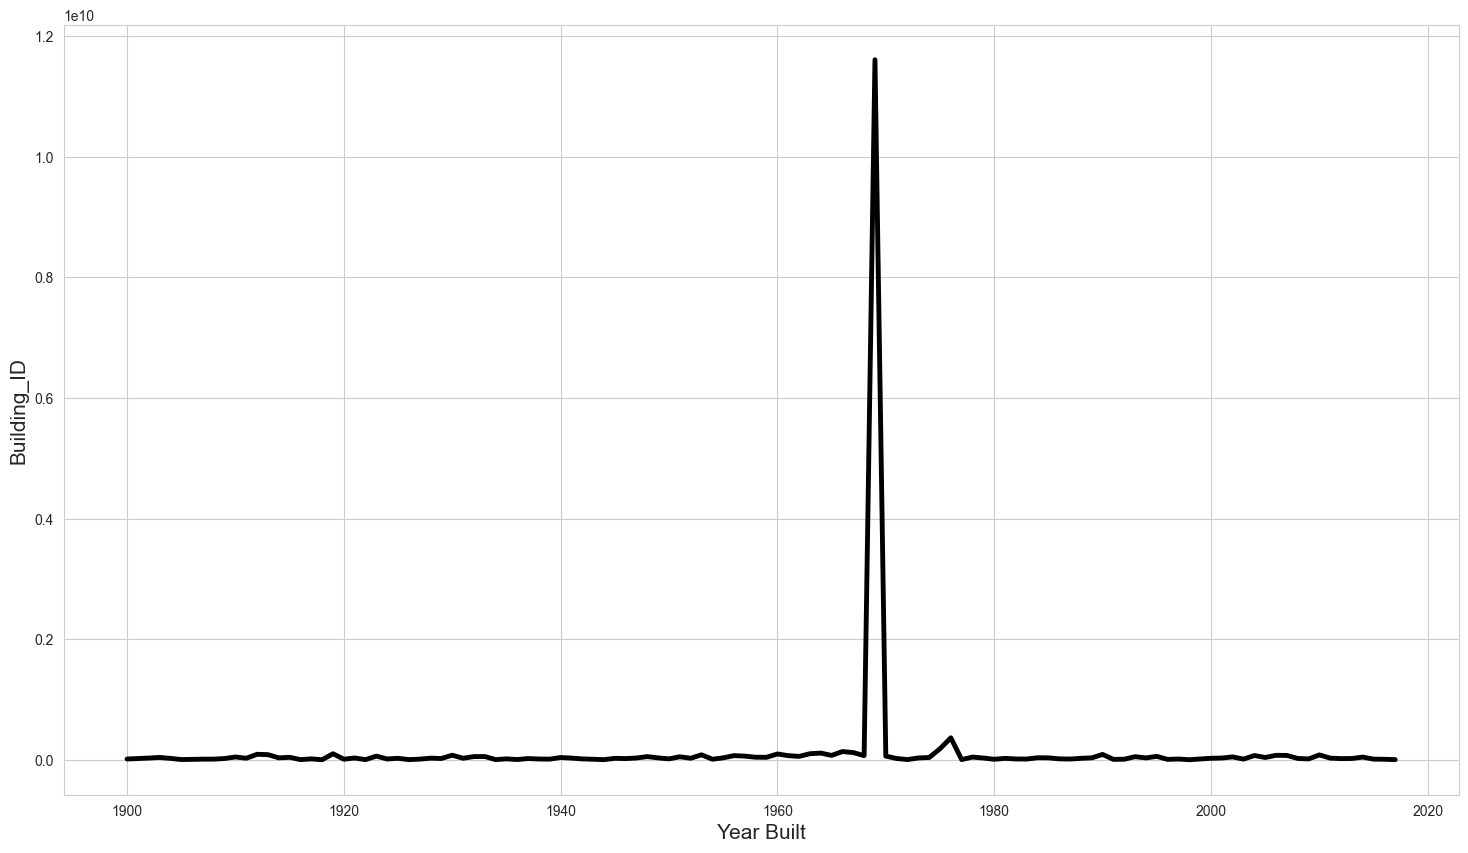

In [31]:
########Newly Added#########
# Check for non-finite values in the 'year_built' column
print(train['year_built'].isna().sum())
print(train['year_built'][~np.isfinite(train['year_built'])].unique())

# Replace non-finite values with a finite value (e.g., the median)
median_year = train['year_built'].median()
train['year_built'] = train['year_built'].fillna(median_year).astype('int64')

# Now plot the line plot
plt.rcParams['figure.figsize'] = (18, 10)
temp_df = train.groupby('year_built').building_id.sum().reset_index()
ax = sns.lineplot(data=temp_df, x='year_built', y='building_id', color='black', linewidth=3.5)
plt.xlabel('Year Built', fontsize=15)
plt.ylabel('Building_ID', fontsize=15)
plt.show()

## 3.10 Floor Count

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\854870055.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




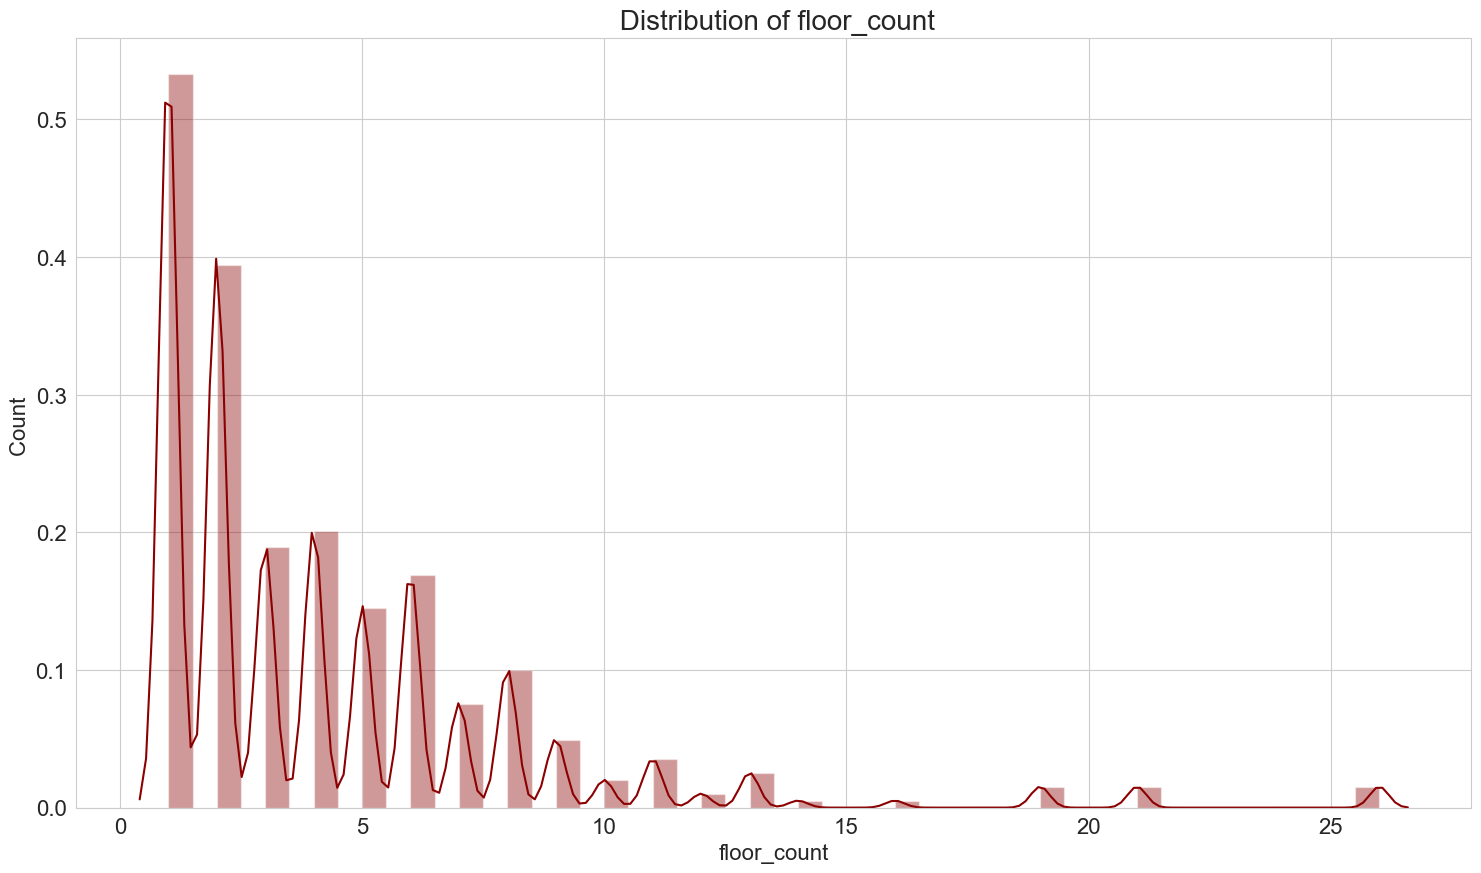

In [32]:
'''Distribution of the Meter Reading'''
distplot(train['floor_count'].dropna(), 'darkred')

There are 16,709,167 missing records in the floor_count variable. Of the 1449 unique building IDs, 1094 don’t have a floor count.

Of those that do, we can see that there aren’t too many buildings with more than 10 floors, while the median number of floors is 3.

## 3.11 Air Temperature

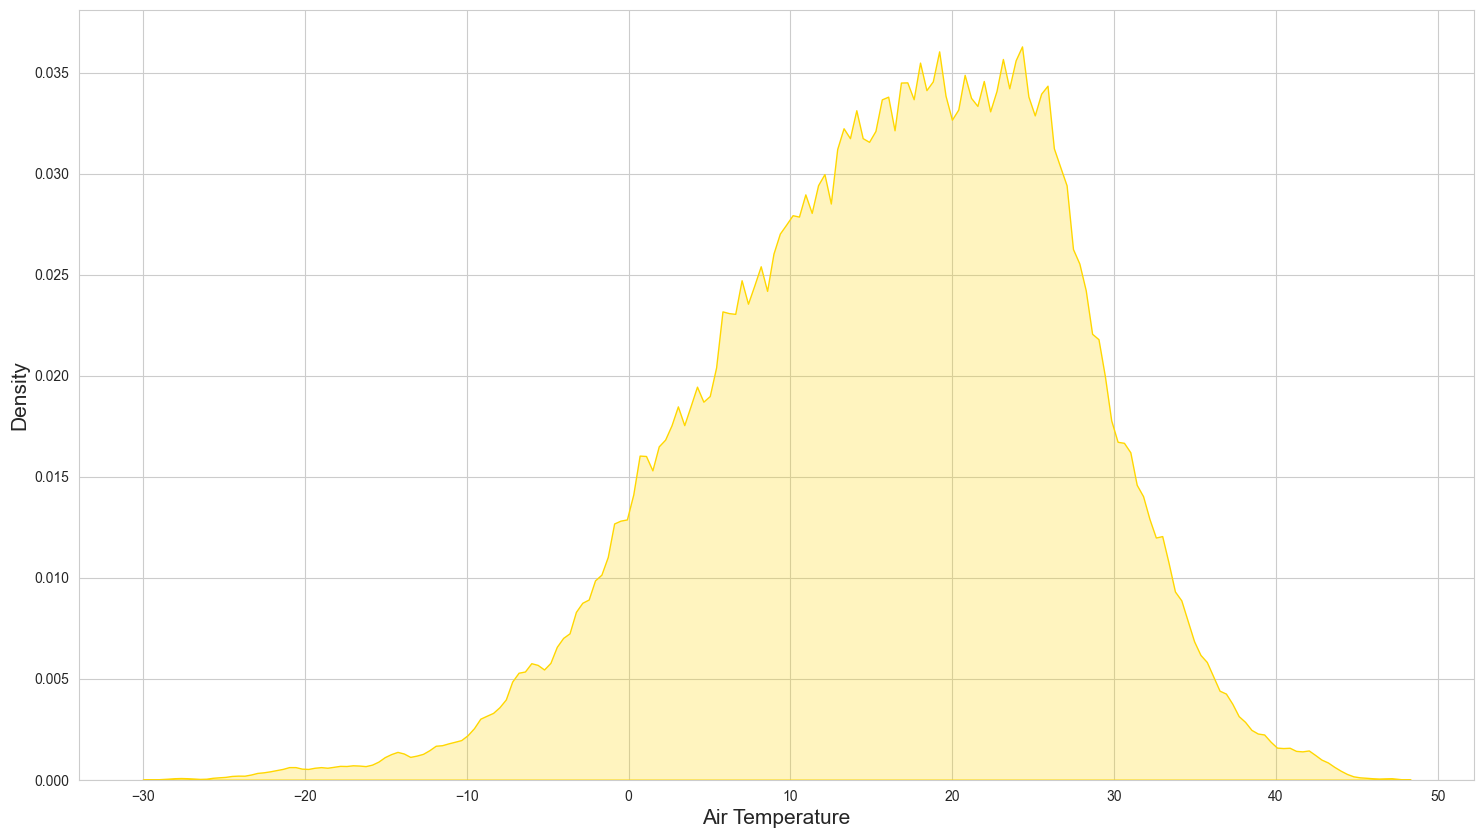

In [33]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['air_temperature'].dropna(), fill = True, color = 'gold')
plt.xlabel('Air Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between ~10 and 25 degrees.

## 3.12 Dew Temperature

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\1970071306.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




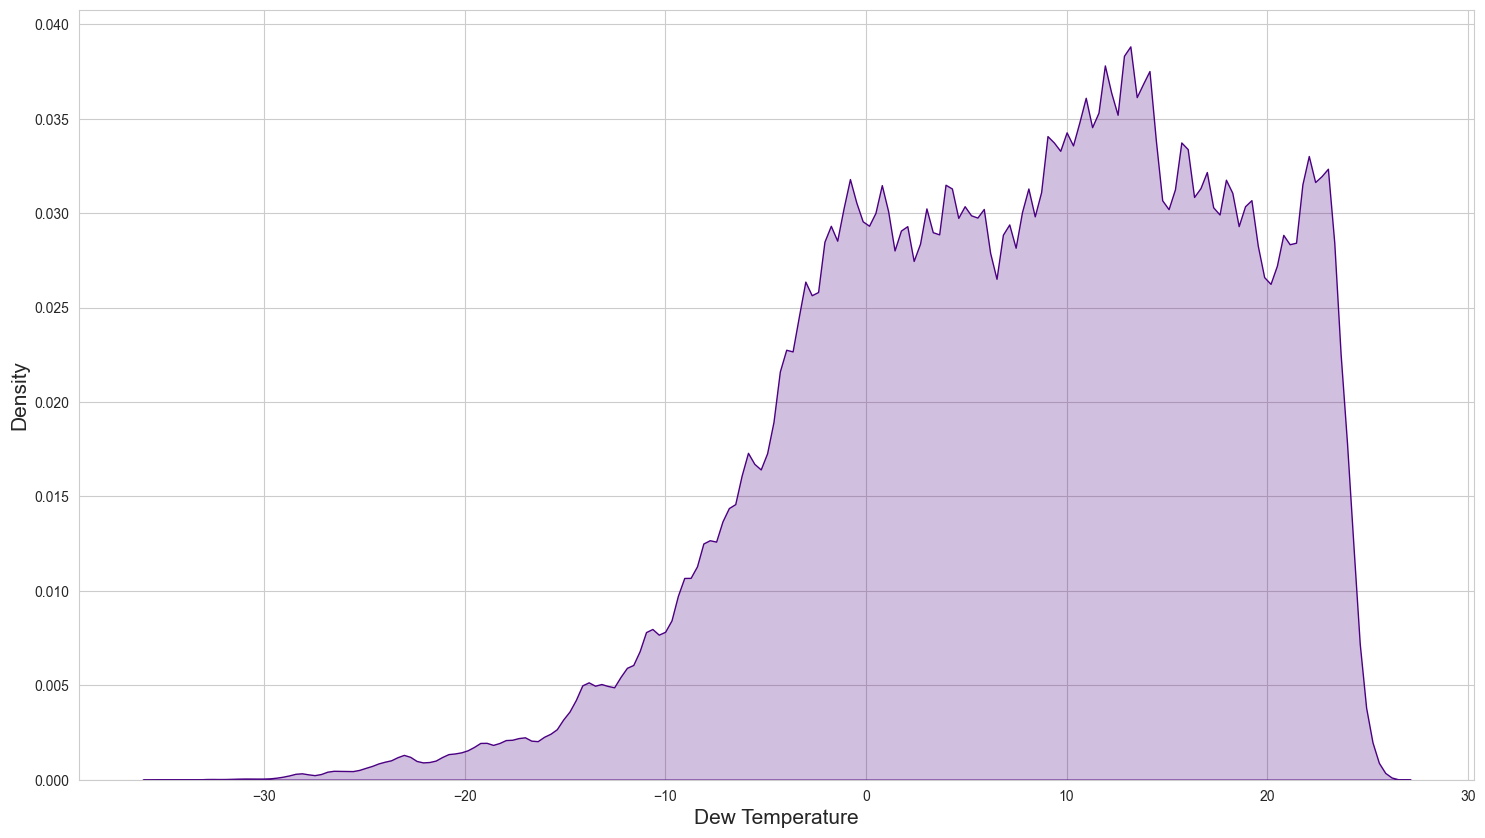

In [34]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['dew_temperature'].dropna(), shade = True, color = 'indigo')
plt.xlabel('Dew Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between ~13 and 25 degrees.

## 3.13 Wind Speed

C:\Users\c23039854\AppData\Local\Temp\ipykernel_824\1412366083.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




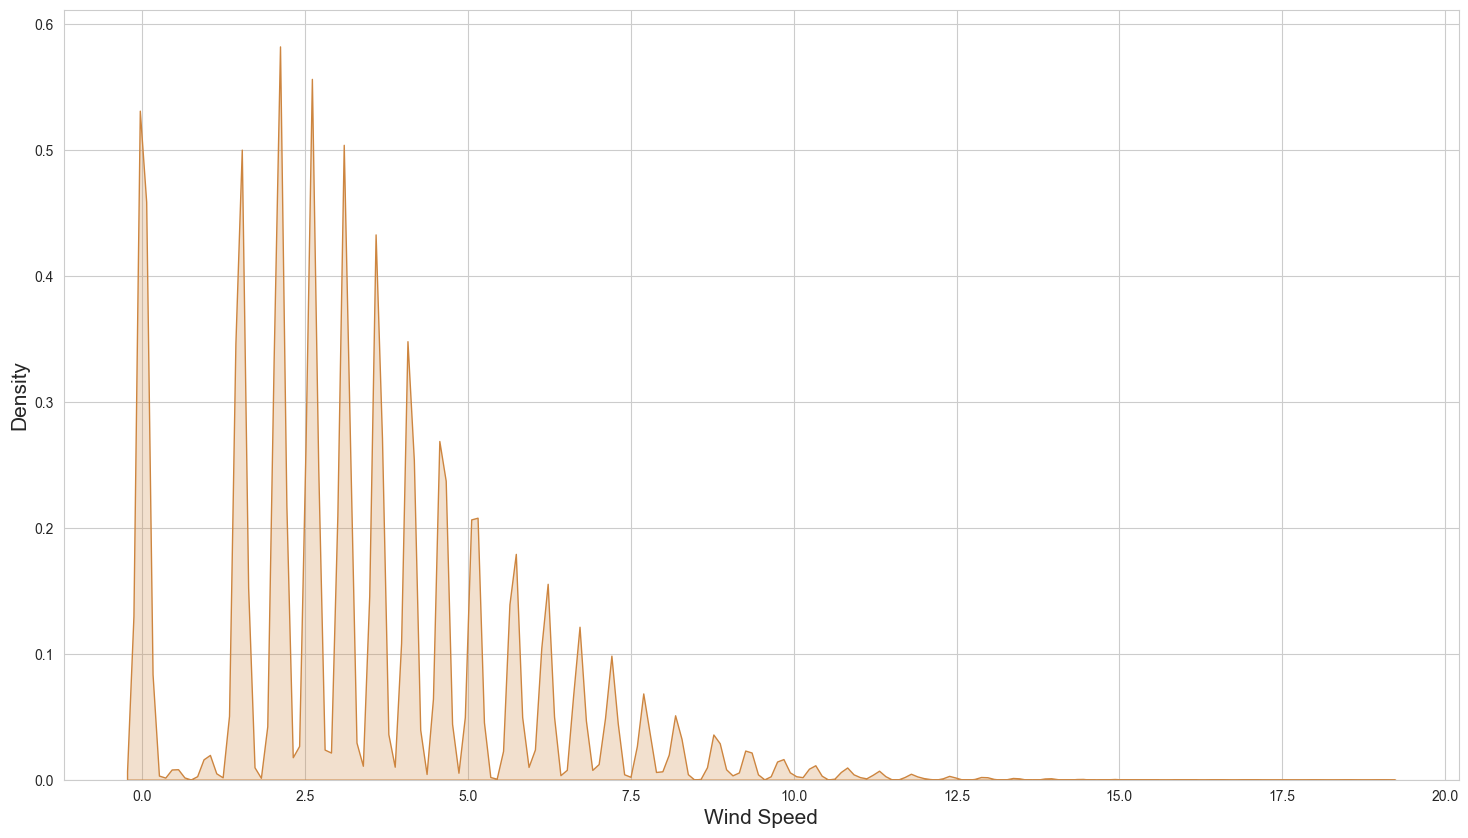

In [35]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['wind_speed'].dropna(), shade = True, color = 'peru')
plt.xlabel('Wind Speed', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between 1.5 and 3.5 Meters per second

In [36]:
def speed_labels(bins:list, units:str) -> list:   
    labels = list()
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))
    return labels

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

spd_bins = [-1, 0, 5, 10, 15, 20, 25, 30, np.inf]
spd_labels = speed_labels(spd_bins, units='m/s')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

In [37]:
calm_count = train[train['wind_speed'] == 0].shape[0]
total_count = len(train)
rose = (train.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)
directions = np.arange(0, 360, 15)

In [38]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)
            # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig


This is a wind rose for TRAIN:

# 4. Feature Engineering - Part II

## 4.1 Imputing Missing variable

In [40]:
#Imputing missing value of year build
# train['year_built'] = np.uint8(train['year_built']-1900)
# test['year_built'] = np.uint8(test['year_built']-1900)
train['year_built'] = np.clip(train['year_built'] - 1900, 0, 255).astype(np.uint8)
test['year_built'] = np.clip(test['year_built'] - 1900, 0, 255).astype(np.uint8)

In [41]:
'''The following variables are either discrete numerical or continuous numerical variables.So the will be imputed by median'''
to_impute_by_median = train.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    train[i].fillna(train[i].median(), inplace = True)

to_impute_by_median = test.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    test[i].fillna(test[i].median(), inplace = True)

## 4.2 Encoding Categorical Variable

In [42]:
#Using sklearn's label encoder method
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use'])
test['primary_use'] = le.fit_transform(test['primary_use'])

In [43]:
#Now extract the nominal variables for one hot encoding of train and test data.
one_hot_train = pd.get_dummies(train['meter'])

one_hot_test = pd.get_dummies(test['meter'])

In [44]:
#Droping variable
train.drop(columns=['meter', 'timestamp', 'weekday_name'], axis = 1, inplace = True)
test.drop(columns=['meter', 'timestamp'], axis = 1, inplace = True)

In [45]:
# concate one hot encoded, other variables together.
train_processed = pd.concat([one_hot_train, train], axis = 1)
test_processed = pd.concat([one_hot_test, test], axis = 1)

# Baseline

In [46]:
"""Let's look at our final train and test data for modelling."""
bold('**Updated train data for modelling:**')
display(train_processed.head(3))
bold('**Updated test data for modelling:**')
display(test_processed.head(3))

**Updated train data for modelling:**

,ChilledWater,Electricity,HotWater,Steam,building_id,meter_reading,site_id,primary_use,square_feet,year_built,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month
0,False,True,False,False,0,0.0,0,0,8.913685,255,...,6.0,20.0,0.0,1019.7,0.0,0.0,0,1,4,1
1,False,True,False,False,1,0.0,0,0,7.908755,255,...,6.0,20.0,0.0,1019.7,0.0,0.0,0,1,4,1
2,False,True,False,False,2,0.0,0,0,8.589886,255,...,6.0,20.0,0.0,1019.7,0.0,0.0,0,1,4,1


**Updated test data for modelling:**

,ChilledWater,Electricity,HotWater,Steam,row_id,building_id,site_id,primary_use,square_feet,year_built,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month
0,False,True,False,False,0,0,0,0,8.913685,255,...,4.0,11.7,0.0,1021.4,100.0,3.6,0,1,6,1
1,False,True,False,False,1,1,0,0,7.908755,255,...,4.0,11.7,0.0,1021.4,100.0,3.6,0,1,6,1
2,False,True,False,False,2,2,0,0,8.589886,255,...,4.0,11.7,0.0,1021.4,100.0,3.6,0,1,6,1


In [47]:
# Convert the 'meter_reading' column to int16
target = train_processed['meter_reading'].astype('int16')

# Drop the 'meter_reading' column from the train and test sets
train = train_processed.drop(['meter_reading'], axis=1)
test = test_processed.drop(['row_id'], axis=1)

In [48]:
cat_feat = ['ChilledWater', 'Electricity', 'HotWater', 'Steam',"site_id", "building_id", "primary_use", "hour", "weekday", "wind_direction"]

In [55]:
sample_train = train.sample(frac=0.0001)
sample_target = target.sample(frac=0.0001)
sample_test = test.sample(frac=0.0001)

In [56]:
print(sample_train.count())

ChilledWater          2022
Electricity           2022
HotWater              2022
Steam                 2022
building_id           2022
site_id               2022
primary_use           2022
square_feet           2022
year_built            2022
floor_count           2022
air_temperature       2022
cloud_coverage        2022
dew_temperature       2022
precip_depth_1_hr     2022
sea_level_pressure    2022
wind_direction        2022
wind_speed            2022
hour                  2022
day                   2022
weekday               2022
month                 2022
dtype: int64


In [57]:
from sklearn.model_selection import train_test_split
X_train = sample_train 
y_train = sample_target  

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Assuming 'test' DataFrame contains test features
X_test = sample_test


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Random Forest Regressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
rf_predictions = rf_regressor.predict(X_val)

In [61]:
print(X_test.count())

ChilledWater          4170
Electricity           4170
HotWater              4170
Steam                 4170
building_id           4170
site_id               4170
primary_use           4170
square_feet           4170
year_built            4170
floor_count           4170
air_temperature       4170
cloud_coverage        4170
dew_temperature       4170
precip_depth_1_hr     4170
sea_level_pressure    4170
wind_direction        4170
wind_speed            4170
hour                  4170
day                   4170
weekday               4170
month                 4170
dtype: int64


In [62]:
# Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
linear_predictions = linear_regressor.predict(X_val)

In [63]:
# Neural Network
mlp_regressor = MLPRegressor()
mlp_regressor.fit(X_train, y_train)
mlp_predictions = mlp_regressor.predict(X_val)

In [64]:
# Calculate Metrics
def calculate_metrics(predictions, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    mse = mean_squared_error(y_true, predictions)
    mae = mean_absolute_error(y_true, predictions)
    return rmse, mse, mae

In [65]:
rf_rmse, rf_mse, rf_mae = calculate_metrics(rf_predictions, y_val)
linear_rmse, linear_mse, linear_mae = calculate_metrics(linear_predictions, y_val)
mlp_rmse, mlp_mse, mlp_mae = calculate_metrics(mlp_predictions, y_val)


In [66]:
# Print Results
print("Random Forest Regressor:")
print("RMSE:", rf_rmse)
print("MSE:", rf_mse)
print("MAE:", rf_mae)
print("\nLinear Regression:")
print("RMSE:", linear_rmse)
print("MSE:", linear_mse)
print("MAE:", linear_mae)
print("\nNeural Network:")
print("RMSE:", mlp_rmse)
print("MSE:", mlp_mse)
print("MAE:", mlp_mae)


Random Forest Regressor:
RMSE: 2.1537353712521687
MSE: 4.638576049382716
MAE: 1.7451604938271603

Linear Regression:
RMSE: 2.1060311533970966
MSE: 4.4353672190791045
MAE: 1.7068998528403847

Neural Network:
RMSE: 2.2288513492448505
MSE: 4.96777833703059
MAE: 1.8040978950894084


# Modeling simple LGBM

In [67]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(sample_train, sample_target, test_size=0.2, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)

gbm = lgb.train({},  # Empty parameter dictionary
                lgb_train)

# Make predictions on the test set
y_pred = gbm.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 1617, number of used features: 20
[LightGBM] [Info] Start training from score 3.650588
RMSE: 2.196273619252145
MSE: 4.823617810622916
MAE: 1.772319465685096


# Prediction and Submission

In [70]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
from tqdm import tqdm

In [75]:
models = [rf_regressor, linear_regressor, mlp_regressor]
folds = 5
i=0
result=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
    result.append(np.expm1(sum([model.predict(test.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

100%|████████████████████████████████████████████████████████████████████████████████| 834/834 [09:19<00:00,  1.49it/s]


In [78]:
print(result)

[8.07620144 7.40203226 7.95662785 ... 8.03030936 8.27815999 8.15139498]


In [80]:
'''Submission'''
result = [arr.reshape(1) if arr.ndim == 0 else arr for arr in result]

# Concatenate the arrays in the 'result' list
concatenated_result = np.concatenate(result)

print(concatenated_result)

[8.07620144 7.40203226 7.95662785 ... 8.03030936 8.27815999 8.15139498]


In [86]:
submission_file_path = 'submission.csv'

if os.path.exists(submission_file_path):
    os.system('icacls "{}" /grant:r {}:(F)'.format(submission_file_path, os.getlogin()))
    submission = pd.read_csv(submission_file_path)  # Read the existing submission file
    submission["meter_reading"] = concatenated_result  # Update the "meter_reading" column
    submission.to_csv(submission_file_path, index=False)  # Save the updated DataFrame to the submission file
    print("Data updated in submission.csv")
else:
    # Create a DataFrame for submission if the file does not exist
    submission = pd.DataFrame(data={'meter_reading': concatenated_result})
    submission.to_csv(submission_file_path, index=False)  # Save the DataFrame to the submission file
    print("Forecasted values saved to submission.csv")

Forecasted values saved to submission.csv
